
### Data Collection and Preprocessing
  - Collect historical energy consumption,holidays, pricing, weather, and population data.
  - Preprocess the data, handle missing values, and engineer features.

In [1]:
## Import Libraries 

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import io 
import os

from bs4 import BeautifulSoup


## Data science libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




### Data Directories 

In [3]:
## Creating two directories to store the data (one for raw data, and one for processed data)
# Create directories for raw and cleaned data if they don't exist
raw_data_dir = 'raw_data'
cleaned_data_dir = 'cleaned_data'
os.makedirs(raw_data_dir, exist_ok=True)
os.makedirs(cleaned_data_dir, exist_ok=True)

### Demand Data

In [4]:
## Getting all demand data from IESO website and putting into a data directory

# URL of the webpage containing the links to the CSV files
url = 'http://reports.ieso.ca/public/Demand/'

# Create a directory to store the downloaded files
os.makedirs('demand_data', exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.content, 'html.parser')

# Find all anchor tags (<a>) that contain links to CSV files
links = soup.find_all('a', href=True)

# Extract the filenames from the href attributes of the anchor tags
csv_files = [link['href'] for link in links if link['href'].endswith('.csv')]

# Download each CSV file and save it in the "data" directory
for filename in csv_files:
    file_url = url + filename
    response = requests.get(file_url)
    with open(os.path.join('demand_data', filename), 'wb') as f:
        f.write(response.content)
        print(f"Downloaded {filename}")

Downloaded PUB_Demand.csv
Downloaded PUB_Demand_2002.csv
Downloaded PUB_Demand_2002_v1.csv
Downloaded PUB_Demand_2003.csv
Downloaded PUB_Demand_2003_v1.csv
Downloaded PUB_Demand_2004.csv
Downloaded PUB_Demand_2004_v1.csv
Downloaded PUB_Demand_2005.csv
Downloaded PUB_Demand_2005_v1.csv
Downloaded PUB_Demand_2006.csv
Downloaded PUB_Demand_2006_v1.csv
Downloaded PUB_Demand_2007.csv
Downloaded PUB_Demand_2007_v1.csv
Downloaded PUB_Demand_2008.csv
Downloaded PUB_Demand_2008_v1.csv
Downloaded PUB_Demand_2009.csv
Downloaded PUB_Demand_2009_v1.csv
Downloaded PUB_Demand_2010.csv
Downloaded PUB_Demand_2010_v1.csv
Downloaded PUB_Demand_2011.csv
Downloaded PUB_Demand_2011_v1.csv
Downloaded PUB_Demand_2012.csv
Downloaded PUB_Demand_2012_v1.csv
Downloaded PUB_Demand_2013.csv
Downloaded PUB_Demand_2013_v1.csv
Downloaded PUB_Demand_2014.csv
Downloaded PUB_Demand_2014_v1.csv
Downloaded PUB_Demand_2015.csv
Downloaded PUB_Demand_2015_v1.csv
Downloaded PUB_Demand_2016.csv
Downloaded PUB_Demand_2016_v1.csv

In [5]:
## Define a function to read the demand data from a CSV file and return a DataFrame in proper format
def read_csv(filename):
    # Read the CSV file into a DataFrame, skipping the first three rows
    df = pd.read_csv(filename, skiprows=[0, 1])
    # Set column names from the fourth row
    df.columns = df.iloc[0]
    # Drop the fourth row
    df = df.drop(index=0).reset_index(drop=True)
    return df

In [6]:
#Defining a function to combine all the CSV files into a single DataFrame

def combine_csvs(directory):
    """Combine all CSV files in a directory into a single DataFrame."""

# List to store DataFrames for each CSV file
    dfs = []

    # Iterate over each CSV file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            # Clean and read the CSV file into a DataFrame
            df = read_csv(file_path)
            dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(dfs, ignore_index=True)

    # Sort by the 'Date' column
    df = df.sort_values('Date')
    return df


In [7]:
## Define a function that takes a DataFrame and returns a new DataFrame with the 'Date' and 'Hour' columns combined into a single 'DateTime' column
def combine_date_hour(df):
    """Combine 'Date' and 'Hour' columns into a single 'DateTime' column."""
    # Convert 'Hour' to 24-hour format as integer and subtract 1
    df['Hour'] = (df['Hour'].astype(int) - 1) % 24  # Ensure hour values are within 0-23 range
    # Combine 'Date' and 'Hour' strings
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'].astype(str) + ':00:00')
    # Drop 'Date' and 'Hour' columns
    df.drop(columns=['Date', 'Hour'], inplace=True)
    # # Sort DataFrame by the 'DateTime' column
    df.sort_values(by='DateTime', inplace=True)
    # Reset index
    df.reset_index(drop=True, inplace=True)
    return df

In [8]:
## Get the combined demand data, sort the date, and return the final dataframe 

# Combine all CSV files in the "data" directory into a single DataFrame
df_d = combine_csvs('demand_data')
# Combine the 'Date' and 'Hour' columns into a single 'DateTime' column
df_d  = combine_date_hour(df_d )
## set index to DateTime
df_d .set_index('DateTime', inplace=True)
## Sort the DataFrame by the 'DateTime' column
df_d .sort_values(by='DateTime', inplace=True)
# Remove duplicate rows
df_d = df_d.drop_duplicates()

# Display the first 50 rows of the DataFrame
df_d .head()

,Market Demand,Ontario Demand
DateTime,,
2002-05-01 00:00:00,14141,14137
2002-05-01 01:00:00,13876,13872
2002-05-01 02:00:00,13974,13820
2002-05-01 03:00:00,13898,13744
2002-05-01 04:00:00,14378,14224


In [9]:
df_d.tail()

,Market Demand,Ontario Demand
DateTime,,
2024-02-22 18:00:00,18881,17863
2024-02-22 19:00:00,18812,17991
2024-02-22 20:00:00,18816,17636
2024-02-22 21:00:00,18522,17138
2024-02-22 22:00:00,17718,16265


In [10]:
# Save the raw demand data to a CSV file in the raw data directory
raw_dem_file_path = os.path.join(raw_data_dir, 'raw_dem_data.csv')
df_d.to_csv(raw_dem_file_path)

print(f"Raw GDP data saved to: {raw_dem_file_path}")

Raw GDP data saved to: raw_data/raw_dem_data.csv


### Pricing Data 






In [11]:
import requests
import os

# URL of the directory containing the CSV files
url = 'http://reports.ieso.ca/public/PriceHOEPPredispOR/'

# Create a directory to store the downloaded files
os.makedirs('price_data', exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.content, 'html.parser')

# Find all anchor tags (<a>) that contain links to CSV files
links = soup.find_all('a', href=True)

# Extract the filenames from the href attributes of the anchor tags
csv_files = [link['href'] for link in links if link['href'].endswith('.csv')]

# Download each CSV file and save it in the "data" directory
for filename in csv_files:
    file_url = url + filename
    response = requests.get(file_url)
    with open(os.path.join('price_data', filename), 'wb') as f:
        f.write(response.content)
        print(f"Downloaded {filename}")



Downloaded PUB_PriceHOEPPredispOR.csv
Downloaded PUB_PriceHOEPPredispOR_2002.csv
Downloaded PUB_PriceHOEPPredispOR_2002_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2003.csv
Downloaded PUB_PriceHOEPPredispOR_2003_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2004.csv
Downloaded PUB_PriceHOEPPredispOR_2004_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2005.csv
Downloaded PUB_PriceHOEPPredispOR_2005_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2006.csv
Downloaded PUB_PriceHOEPPredispOR_2006_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2007.csv
Downloaded PUB_PriceHOEPPredispOR_2007_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2008.csv
Downloaded PUB_PriceHOEPPredispOR_2008_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2009.csv
Downloaded PUB_PriceHOEPPredispOR_2009_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2010.csv
Downloaded PUB_PriceHOEPPredispOR_2010_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2011.csv
Downloaded PUB_PriceHOEPPredispOR_2011_v1.csv
Downloaded PUB_PriceHOEPPredispOR_2012.csv
Downloaded PUB_PriceHOEPPredi

In [12]:
## Define a combine csv function to combine all the CSV files into a single DataFrame for price data 
import re 
import os 
def p_combine_csvs(directory):
    """Combine all CSV files in a directory into a single DataFrame."""
    # List to store DataFrames for each CSV file
    dfs = []

    # Set to store combined filenames
    combined_files = []

    # Iterate over each CSV file in the directory
    for filename in os.listdir(directory):
        if filename.startswith('PUB_PriceHOEPPredispOR_') and filename.endswith('.csv'):
            match = re.match(r'PUB_PriceHOEPPredispOR_(\d{4}).csv', filename)
            if match:
                year = match.group(1)
                combined_filename = f'PUB_PriceHOEPPredispOR_{year}.csv'
                if combined_filename not in combined_files:
                    combined_files.append(combined_filename)
                    file_path = os.path.join(directory, filename)
                    # Clean and read the CSV file into a DataFrame
                    df = read_csv(file_path)
                    dfs.append(df)
                    print(f"Combined {filename}")
                
    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(dfs, ignore_index=True)

    # Sort by the 'Date' column
    df = df.sort_values('Date')
    return df

In [13]:
# Combine all CSV files in the "data" directory into a single DataFrame
df = p_combine_csvs('price_data')
# Combine the 'Date' and 'Hour' columns into a single 'DateTime' column
df = combine_date_hour(df)
## set index to DateTime
df.set_index('DateTime', inplace=True)
## Sort the DataFrame by the 'DateTime' column
df.sort_values(by='DateTime', inplace=True)
# Display the first 50 rows of the DataFrame
df.head()

Combined PUB_PriceHOEPPredispOR_2005.csv
Combined PUB_PriceHOEPPredispOR_2011.csv
Combined PUB_PriceHOEPPredispOR_2010.csv
Combined PUB_PriceHOEPPredispOR_2004.csv
Combined PUB_PriceHOEPPredispOR_2012.csv
Combined PUB_PriceHOEPPredispOR_2006.csv
Combined PUB_PriceHOEPPredispOR_2007.csv
Combined PUB_PriceHOEPPredispOR_2013.csv
Combined PUB_PriceHOEPPredispOR_2017.csv
Combined PUB_PriceHOEPPredispOR_2003.csv
Combined PUB_PriceHOEPPredispOR_2002.csv
Combined PUB_PriceHOEPPredispOR_2016.csv
Combined PUB_PriceHOEPPredispOR_2014.csv
Combined PUB_PriceHOEPPredispOR_2015.csv
Combined PUB_PriceHOEPPredispOR_2024.csv
Combined PUB_PriceHOEPPredispOR_2018.csv
Combined PUB_PriceHOEPPredispOR_2019.csv
Combined PUB_PriceHOEPPredispOR_2022.csv
Combined PUB_PriceHOEPPredispOR_2023.csv
Combined PUB_PriceHOEPPredispOR_2009.csv
Combined PUB_PriceHOEPPredispOR_2021.csv
Combined PUB_PriceHOEPPredispOR_2020.csv
Combined PUB_PriceHOEPPredispOR_2008.csv


,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
DateTime,,,,,,,
2002-05-01 00:00:00,22.97,14.53,14.53,14.53,NaN,NaN,NaN
2002-05-01 01:00:00,23.27,21.31,21.37,21.37,NaN,NaN,NaN
2002-05-01 02:00:00,24.54,25.45,21.38,21.38,NaN,NaN,NaN
2002-05-01 03:00:00,15.17,24.92,24.92,14.53,NaN,NaN,NaN
2002-05-01 04:00:00,23.59,27.38,27.38,27.4,NaN,NaN,NaN


In [14]:
df.tail()

,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
DateTime,,,,,,,
2024-02-22 19:00:00,41.37,43.03,43.03,48.13,5.17,5.17,5.04
2024-02-22 20:00:00,48.66,51.00,51.00,35.73,5.02,4.86,4.71
2024-02-22 21:00:00,30.30,28.93,28.93,33.64,1.21,0.15,0.15
2024-02-22 22:00:00,27.78,28.76,28.76,28.76,1.21,0.15,0.15
2024-02-22 23:00:00,25.62,27.71,27.71,28.07,1.20,0.15,0.15


In [15]:
## Check for missing values in the HOEP column 

# # Check for missing values in the 'HOEP' column
missing_values = df['HOEP'].isna().sum()
print(f"Number of missing values in the 'HOEP' column: {missing_values}")

## Check HEOP column type 
# # Check the data type of the 'HOEP' column
print(f"Data type of the 'HOEP' column: {df['HOEP'].dtype}")

## Change the data type of the 'HOEP' column to float

# Convert the 'HOEP' column to float
df['HOEP'] = pd.to_numeric(df['HOEP'], errors='coerce')

print(f"Data type of the 'HOEP' column: {df['HOEP'].dtype}")

missing_values = df['HOEP'].isna().sum()
print(f"Number of missing values in the 'HOEP' column: {missing_values}")




Number of missing values in the 'HOEP' column: 0
Data type of the 'HOEP' column: object
Data type of the 'HOEP' column: float64
Number of missing values in the 'HOEP' column: 8


In [16]:
# Save the raw demand data to a CSV file in the raw data directory
raw_price_file_path = os.path.join(raw_data_dir, 'raw_price_data.csv')
df.to_csv(raw_price_file_path)

print(f"Raw Price data saved to: {raw_price_file_path}")

Raw GDP data saved to: raw_data/raw_price_data.csv


#### Weather Data (Environment Canada)




In [17]:
## get weather data for all 169 unique ontario weather stations from dates starting at 2002 to 2024 


## Url for the weather data

url = 'https://dd.weather.gc.ca/climate/observations/hourly/csv/ON/'

## Create a directory to store the downloaded files

os.makedirs('weather_data', exist_ok=True)

## Define station IDs and dates

station_ids = df_station_ids_dates['Station ID'].unique()

## Dates from 2002 to 2024

unique_dates = df_station_ids_dates['Date'].unique()
dates = range(2002, 2025)

## Download all the weather data for each station and date (169 stations and 2002-2024 dates)

def extract_station_date(file_name):
    parts = file_name.split('_')
    station_id = parts[3]
    date = parts[4]
    return station_id, date


for station_id in station_ids:
    for date in dates:
        # Construct the filename
        filename = f'climate_hourly_ON_{station_id}_{date}_P1H.csv'
        # Construct the file URL
        file_url = url + filename
        # Send a GET request to the file URL
        response = requests.get(file_url)
        # Check if the file exists
        if response.status_code == 200:
            # Save the file in the weather_data directory
            with open(os.path.join('weather_data', filename), 'wb') as f:
                f.write(response.content)
                print(f"Downloaded {filename}")


Click me to download CSV data:
http://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=51459&Year=2020&Month=01&timeframe=1


In [2]:

import os
import glob
import pandas as pd

def get_station_data(station_ids, directory):
    """
    Concatenate weather data from multiple stations.
    
    Parameters:
        station_ids (list): List of station IDs to analyze.
        directory (str): Directory containing weather data CSV files.
        
    Returns:
        DataFrame: Concatenated weather data for all specified stations.
    """
    # Initialize an empty list to store DataFrames for each station
    dfs = []

    # Iterate over each station ID
    for station_id in station_ids:
        # Define the pattern for files corresponding to the current station ID
        pattern = os.path.join(directory, f"*{station_id}*.csv")

        # Find all files matching the pattern
        station_data_files = glob.glob(pattern)

        # Concatenate data from all files for the current station ID
        df_station = pd.concat(
            (pd.read_csv(file, encoding='latin-1') for file in station_data_files),
            ignore_index=True
        )

        # Append the concatenated DataFrame to the list
        dfs.append(df_station)

    # Concatenate data from all stations
    df = pd.concat(dfs, ignore_index=True)
    
    return df


In [3]:

def preprocess_weather_data(df):
    """
    Preprocess weather data by renaming columns, converting datetime, and extracting specified columns.
    
    Parameters:
        df (DataFrame): Input DataFrame containing weather data.
        
    Returns:
        DataFrame: Processed DataFrame containing specified columns.
    """
    # Rename 'Date/Time (LST)' column to 'DateTime'
    df.rename(columns={'Date/Time (LST)': 'DateTime'}, inplace=True)
    
    # Convert the 'DateTime' column to a datetime type
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index('DateTime', inplace=True)
    df.sort_index(inplace=True)
    
    # List of columns to extract
    columns_to_extract = ['Temp (°C)', 'Dew Point Temp (°C)', 'Rel Hum (%)', 'Wind Spd (km/h)', 
                          'Visibility (km)', 'Stn Press (kPa)', 'Weather']
    
    # Extract the specified columns
    df = df[columns_to_extract]
    
    return df

In [ ]:
## Ottawa Stations 
station_ids = ["6106000", "6106001"]
weather_data_directory = "weather_data"
weather_data = get_station_data(station_ids, directory=weather_data_directory)
Ottawa_raw_data = preprocess_weather_data(weather_data)
Ottawa_raw_data.to_csv("Toronto_weather_data.csv")

In [ ]:
# Toronto Stations

station_ids = ["6158733", "6158731"]
weather_data_directory = "weather_data"
weather_data = get_station_data(station_ids, directory=weather_data_directory)
Toronto_raw_data = preprocess_weather_data(weather_data)
Toronto_raw_data.to_csv("Toronto_weather_data.csv")


In [19]:
df.tail()

,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
DateTime,,,,,,,
2024-02-22 19:00:00,41.37,43.03,43.03,48.13,5.17,5.17,5.04
2024-02-22 20:00:00,48.66,51.00,51.00,35.73,5.02,4.86,4.71
2024-02-22 21:00:00,30.30,28.93,28.93,33.64,1.21,0.15,0.15
2024-02-22 22:00:00,27.78,28.76,28.76,28.76,1.21,0.15,0.15
2024-02-22 23:00:00,25.62,27.71,27.71,28.07,1.20,0.15,0.15


In [20]:
# month = "01" # January
# year = "2020" # 2020
# stationID = 51442 #Vancouver

# base_url = "http://climate.weather.gc.ca/climate_data/bulk_data_e.html?"
# query_url = "format=csv&stationID={}&Year={}&Month={}&timeframe=1".format(stationID, year, month)
# api_endpoint = base_url + query_urlb

# print("Click me to download CSV data:")
# print(api_endpoint)

# https://climate.weather.gc.ca/climate_data/daily_data_e.html?

### Ontario Holidays 



In [21]:
## Add holidays to the demand data frame
## Copy deamnd df 
df3 = df_d.copy()

In [22]:
import holidays 
hols = holidays.Canada(state = 'ON')


In [23]:
## Add holidays to the demand data frame

df3['Holiday'] = pd.Series(df3.index.date).apply(lambda x: x in hols).values

In [24]:
df3.head()

,Market Demand,Ontario Demand,Holiday
DateTime,,,
2002-05-01 00:00:00,14141,14137,False
2002-05-01 01:00:00,13876,13872,False
2002-05-01 02:00:00,13974,13820,False
2002-05-01 03:00:00,13898,13744,False
2002-05-01 04:00:00,14378,14224,False


In [25]:
##Keep date time and holiday columns

df3 = df3[['Holiday']]
df3.head()

,Holiday
DateTime,
2002-05-01 00:00:00,False
2002-05-01 01:00:00,False
2002-05-01 02:00:00,False
2002-05-01 03:00:00,False
2002-05-01 04:00:00,False


In [26]:
## Convert the false and true to 0 and 1

df3['Holiday'] = df3['Holiday'].astype(int)
df3.head()


,Holiday
DateTime,
2002-05-01 00:00:00,0
2002-05-01 01:00:00,0
2002-05-01 02:00:00,0
2002-05-01 03:00:00,0
2002-05-01 04:00:00,0


In [27]:
df3.tail()

,Holiday
DateTime,
2024-02-22 18:00:00,0
2024-02-22 19:00:00,0
2024-02-22 20:00:00,0
2024-02-22 21:00:00,0
2024-02-22 22:00:00,0


In [28]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 190370 entries, 2002-05-01 00:00:00 to 2024-02-22 22:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   Holiday  190370 non-null  int64
dtypes: int64(1)
memory usage: 2.9 MB


In [29]:
## Save the holiday data to a CSV file in the cleaned data directory

df3.to_csv('cleaned_data/holiday_data.csv')

## Population Data 



In [30]:


# URL of the webpage containing the links to the CSV files
url = 'https://www150.statcan.gc.ca/t1/wds/rest/getFullTableDownloadCSV/14100287/en'

# Create a directory to store the downloaded files
os.makedirs('population_data', exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.content, 'html.parser')

# Find all anchor tags (<a>) that contain links to CSV files
links = soup.find_all('a', href=True)

# Extract the filenames from the href attributes of the anchor tags
csv_files = [link['href'] for link in links if link['href'].endswith('.csv')]

# Download each CSV file and save it in the "data" directory
for filename in csv_files:
    file_url = url + filename
    response = requests.get(file_url)
    with open(os.path.join('population_data', filename), 'wb') as f:
        f.write(response.content)
        print(f"Downloaded {filename}")


/var/folders/vr/r8mf2bqs5rq239fpzg2_n3z00000gn/T/ipykernel_70349/640124098.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(response.content, 'html.parser')


In [31]:
import os
import requests
from bs4 import BeautifulSoup

# URL of the webpage containing the links to the CSV files
url = "https://www150.statcan.gc.ca/t1/wds/rest/getFullTableDownloadCSV/14100287/en"

# Create a directory to store the downloaded files
os.makedirs('population_data', exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Check the content type of the response
content_type = response.headers.get('content-type')
print("Content-Type:", content_type)

# Parse the HTML content of the webpage if it's HTML
if 'text/html' in content_type:
    # Parse the HTML content of the webpage
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all anchor tags (<a>) that contain links to CSV files
    links = soup.find_all('a', href=True)

    # Extract the filenames from the href attributes of the anchor tags
    csv_files = [link['href'] for link in links if link['href'].endswith('.csv')]

    # Download each CSV file and save it in the "population_data" directory
    for filename in csv_files:
        file_url = url + filename
        response = requests.get(file_url)
        with open(os.path.join('population_data', filename), 'wb') as f:
            f.write(response.content)
            print(f"Downloaded {filename}")
else:
    # If the content type is not HTML, handle it accordingly (e.g., save it directly to a file)
    with open('population_data/full_table.csv', 'wb') as f:
        f.write(response.content)
        print("Downloaded full_table.csv")


Content-Type: application/json
Downloaded full_table.csv


In [32]:
import os
import requests

# URL of the webpage containing the links to the CSV files
url = 'https://www150.statcan.gc.ca/t1/wds/rest/getFullTableDownloadCSV/14100287/en'

# Create a directory to store the downloaded files
os.makedirs('population_data', exist_ok=True)

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON content of the response
    json_data = response.json()
    
    # Extract the download link from the JSON data
    download_link = json_data['object']
    
    # Download the CSV file and save it in the "population_data" directory
    filename = 'full_table.csv'
    response = requests.get(download_link)
    if response.status_code == 200:
        with open(os.path.join('population_data', filename), 'wb') as f:
            f.write(response.content)
            print(f"Downloaded {filename}")
    else:
        print("Failed to download the CSV file.")
else:
    print("Failed to retrieve data from the URL.")


Downloaded full_table.csv


In [40]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the website to scrape
url = 'https://www.neilsberg.com/insights/ontario-or-population-by-year/'

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table containing population data
table = soup.find('table')

# Extract table headers
headers = [th.text.strip() for th in table.find_all('th')]

# Extract table rows
data = []
for row in table.find_all('tr')[1:]:
    row_data = [td.text.strip() for td in row.find_all('td')]
    data.append(row_data)

# Create a DataFrame
df_pop = pd.DataFrame(data, columns=headers)


In [41]:
df_pop.head()

,Year,Population,Year on Year Change,Change in Percent
0,2000,"11,216",-,-
1,2001,"11,283",67,0.6%
2,2002,"11,278",-5,-0.04%
3,2003,"11,229",-49,-0.43%
4,2004,"11,178",-51,-0.45%


In [42]:
# Save the raw GDP data to a CSV file in the raw data directory
raw_pop_file_path = os.path.join(raw_data_dir, 'raw_pop_data.csv')
df_pop.to_csv(raw_pop_file_path)

print(f"Raw population data saved to: {raw_pop_file_path}")

Raw population data saved to: raw_data/raw_pop_data.csv


In [44]:
## Get the population data from the CSV file
df_pop = pd.read_csv('raw_data/raw_pop_data.csv')

## Remove unnamed: 0 column
df_pop = df_pop.drop(columns = ['Unnamed: 0'])

df_pop.head(30)

,Year,Population,Year on Year Change,Change in Percent
0,2000,"11,216",-,-
1,2001,"11,283",67,0.6%
2,2002,"11,278",-5,-0.04%
3,2003,"11,229",-49,-0.43%
4,2004,"11,178",-51,-0.45%
5,2005,"11,196",18,0.16%
6,2006,"11,199",3,0.03%
7,2007,"11,236",37,0.33%
8,2008,"11,152",-84,-0.75%
9,2009,"11,123",-29,-0.26%


### GDP Data
Downloaded manually for this iteration from 
https://data.ontario.ca/dataset/ontario-economic-accounts/resource/98f4bed6-2481-4c0b-83e5-009c35bfeb5f

In [47]:
## Read xlsx file 

df_gdp = pd.read_excel('Economic_data/ON_GDP.xlsx')
pd.set_option('display.max_columns', None)
df_gdp.head(100)


,"TABLE 1\nOEA Tables - Quarterly Data\nONTARIO GROSS DOMESTIC PRODUCT, INCOME-BASED\nSeasonally adjusted data at annual rates, millions of dollars",1981 I,1981 II,1981 III,1981 IV,1982 I,1982 II,1982 III,1982 IV,1983 I,1983 II,1983 III,1983 IV,1984 I,1984 II,1984 III,1984 IV,1985 I,1985 II,1985 III,1985 IV,1986 I,1986 II,1986 III,1986 IV,1987 I,1987 II,1987 III,1987 IV,1988 I,1988 II,1988 III,1988 IV,1989 I,1989 II,1989 III,1989 IV,1990 I,1990 II,1990 III,1990 IV,1991 I,1991 II,1991 III,1991 IV,1992 I,1992 II,1992 III,1992 IV,1993 I,1993 II,1993 III,1993 IV,1994 I,1994 II,1994 III,1994 IV,1995 I,1995 II,1995 III,1995 IV,1996 I,1996 II,1996 III,1996 IV,1997 I,1997 II,1997 III,1997 IV,1998 I,1998 II,1998 III,1998 IV,1999 I,1999 II,1999 III,1999 IV,2000 I,2000 II,2000 III,2000 IV,2001 I,2001 II,2001 III,2001 IV,2002 I,2002 II,2002 III,2002 IV,2003 I,2003 II,2003 III,2003 IV,2004 I,2004 II,2004 III,2004 IV,2005 I,2005 II,2005 III,2005 IV,2006 I,2006 II,2006 III,2006 IV,2007 I,2007 II,2007 III,2007 IV,2008 I,2008 II,2008 III,2008 IV,2009 I,2009 II,2009 III,2009 IV,2010 I,2010 II,2010 III,2010 IV,2011 I,2011 II,2011 III,2011 IV,2012 I,2012 II,2012 III,2012 IV,2013 I,2013 II,2013 III,2013 IV,2014 I,2014 II,2014 III,2014 IV,2015 I,2015 II,2015 III,2015 IV,2016 I,2016 II,2016 III,2016 IV,2017 I,2017 II,2017 III,2017 IV,2018 I,2018 II,2018 III,2018 IV,2019 I,2019 II,2019 III,2019 IV,2020 I,2020 II,2020 III,2020 IV,2021 I,2021 II,2021 III,2021 IV,2022 I,2022 II,2022 III,2022 IV,2023 I,2023 II,2023 III
0,1. Compensation of employees (domestic basis),73594,74276.0,74047.0,73763.0,77131.0,79459.0,80734.0,83388.0,83532.0,85513.0,86800.0,87667.0,90237.0,93525.0,96677.0,99762.0,101774.0,103715.0,105839.0,107864.0,110215.0,112775.0,115284.0,118402.0,121569.0,124984.0,127635.0,131236.0,135757.0,139371.0,142568.0,146213.0,149293.0,152623.0,154758.0,157449.0,158155.0,159054.0,158371.0,158324.0,159406.0,160678.0,162464.0,163800.0,163785.0,164652.0,165035.0,165517.0,166091.0,166043.0,166333.0,165989.0,166753.0,169378.0,170875.0,172434.0,173892.0,174982.0,176667.0,177139.0,177535.0,178701.0,180962.0,184367.0,186522.0,189603.0,194093.0,195716.0,199720.0,202458.0,203874.0,208110.0,210855.0,215092.0,219454.0,225089.0,231179.0,238459.0,242178.0,243843.0,244670.0,245357.0,245566.0,245671.0,248242.0,251482.0,255280.0,258770.0,260700.0,261760.0,263623.0,267175.0,271763.0,275923.0,279255.0,280736.0,283480.0,287884.0,291764.0,295302.0,297029.0,300381.0,304982.0,309111.0,313786.0,318216.0,320992.0,323150.0,326092.0,329243.0,329468.0,327872.0,323947.0,321409.0,321929.0,325692.0,327584.0,330811.0,335549.0,340675.0,346542.0,347357.0,349813.0,352130.0,355618.0,359212.0,362499.0,364646.0,368811.0,370234.0,372613.0,376175.0,378213.0,382523.0,387819.0,389582.0,395764.0,399844.0,403696.0,407827.0,405117.0,408748.0,409388.0,412593.0,418609.0,422553.0,430259.0,439095.0,447318.0,450752.0,455106.0,460991.0,463206.0,470038.0,478286.0,483870.0,478849.0,440796.0,476672.0,491266.0,504252.0,504796.0,521261.0,534031.0,550190.0,559532.0,566746.0,570532.0,583561.0,596873.0,605043.0
1,Per cent change from previous quarter at quart...,-,0.9,-0.3,-0.4,4.6,3.0,1.6,3.3,0.2,2.4,1.5,1.0,2.9,3.6,3.4,3.2,2.0,1.9,2.0,1.9,2.2,2.3,2.2,2.7,2.7,2.8,2.1,2.8,3.4,2.7,2.3,2.6,2.1,2.2,1.4,1.7,0.4,0.6,-0.4,0.0,0.7,0.8,1.1,0.8,0.0,0.5,0.2,0.3,0.3,0.0,0.2,-0.2,0.5,1.6,0.9,0.9,0.8,0.6,1.0,0.3,0.2,0.7,1.3,1.9,1.2,1.7,2.4,0.8,2.0,1.4,0.7,2.1,1.3,2.0,2.0,2.6,2.7,3.1,1.6,0.7,0.3,0.3,0.1,0.0,1.0,1.3,1.5,1.4,0.7,0.4,0.7,1.3,1.7,1.5,1.2,0.5,1.0,1.6,1.3,1.2,0.6,1.1,1.5,1.4,1.5,1.4,0.9,0.7,0.9,1.0,0.1,-0.5,-1.2,-0.8,0.2,1.2,0.6,1.0,1.4,1.5,1.7,0.2,0.7,0.7,1.0,1.0,0.9,0.6,1.1,0.4,0.6,1.0,0.5,1.1,1.4,0.5,1.6,1.0,1.0,1.0,-0.7,0.9,0.2,0.8,1.5,0.9,1.8,2.1,1.9,0.8,1.0,1.3,0.5,1.5,1.8,1.2,-1.0,-7.9,8.1,3.1,2.6,0.1,3.3,2.4,3.0,1.7,1.3,0.7,2.3,2.3,1.4
2,2. Gross operating surplus,26959,27352.0,26584.0,25222.0,24959.0,26011.0,26696.0,27410.0,30258.0,32062.0,34613.0,36467.0,37863.0,39787.0,39801.0,40633.0,42852.0,44373.0

In [48]:
# Save the raw GDP data to a CSV file in the raw data directory
raw_gdp_file_path = os.path.join(raw_data_dir, 'raw_gdp_data.csv')
df_gdp.to_csv(raw_gdp_file_path)

print(f"Raw GDP data saved to: {raw_gdp_file_path}")


Raw GDP data saved to: raw_data/raw_gdp_data.csv


In [49]:
df_gdp.head(100)

,"TABLE 1\nOEA Tables - Quarterly Data\nONTARIO GROSS DOMESTIC PRODUCT, INCOME-BASED\nSeasonally adjusted data at annual rates, millions of dollars",1981 I,1981 II,1981 III,1981 IV,1982 I,1982 II,1982 III,1982 IV,1983 I,1983 II,1983 III,1983 IV,1984 I,1984 II,1984 III,1984 IV,1985 I,1985 II,1985 III,1985 IV,1986 I,1986 II,1986 III,1986 IV,1987 I,1987 II,1987 III,1987 IV,1988 I,1988 II,1988 III,1988 IV,1989 I,1989 II,1989 III,1989 IV,1990 I,1990 II,1990 III,1990 IV,1991 I,1991 II,1991 III,1991 IV,1992 I,1992 II,1992 III,1992 IV,1993 I,1993 II,1993 III,1993 IV,1994 I,1994 II,1994 III,1994 IV,1995 I,1995 II,1995 III,1995 IV,1996 I,1996 II,1996 III,1996 IV,1997 I,1997 II,1997 III,1997 IV,1998 I,1998 II,1998 III,1998 IV,1999 I,1999 II,1999 III,1999 IV,2000 I,2000 II,2000 III,2000 IV,2001 I,2001 II,2001 III,2001 IV,2002 I,2002 II,2002 III,2002 IV,2003 I,2003 II,2003 III,2003 IV,2004 I,2004 II,2004 III,2004 IV,2005 I,2005 II,2005 III,2005 IV,2006 I,2006 II,2006 III,2006 IV,2007 I,2007 II,2007 III,2007 IV,2008 I,2008 II,2008 III,2008 IV,2009 I,2009 II,2009 III,2009 IV,2010 I,2010 II,2010 III,2010 IV,2011 I,2011 II,2011 III,2011 IV,2012 I,2012 II,2012 III,2012 IV,2013 I,2013 II,2013 III,2013 IV,2014 I,2014 II,2014 III,2014 IV,2015 I,2015 II,2015 III,2015 IV,2016 I,2016 II,2016 III,2016 IV,2017 I,2017 II,2017 III,2017 IV,2018 I,2018 II,2018 III,2018 IV,2019 I,2019 II,2019 III,2019 IV,2020 I,2020 II,2020 III,2020 IV,2021 I,2021 II,2021 III,2021 IV,2022 I,2022 II,2022 III,2022 IV,2023 I,2023 II,2023 III
0,1. Compensation of employees (domestic basis),73594,74276.0,74047.0,73763.0,77131.0,79459.0,80734.0,83388.0,83532.0,85513.0,86800.0,87667.0,90237.0,93525.0,96677.0,99762.0,101774.0,103715.0,105839.0,107864.0,110215.0,112775.0,115284.0,118402.0,121569.0,124984.0,127635.0,131236.0,135757.0,139371.0,142568.0,146213.0,149293.0,152623.0,154758.0,157449.0,158155.0,159054.0,158371.0,158324.0,159406.0,160678.0,162464.0,163800.0,163785.0,164652.0,165035.0,165517.0,166091.0,166043.0,166333.0,165989.0,166753.0,169378.0,170875.0,172434.0,173892.0,174982.0,176667.0,177139.0,177535.0,178701.0,180962.0,184367.0,186522.0,189603.0,194093.0,195716.0,199720.0,202458.0,203874.0,208110.0,210855.0,215092.0,219454.0,225089.0,231179.0,238459.0,242178.0,243843.0,244670.0,245357.0,245566.0,245671.0,248242.0,251482.0,255280.0,258770.0,260700.0,261760.0,263623.0,267175.0,271763.0,275923.0,279255.0,280736.0,283480.0,287884.0,291764.0,295302.0,297029.0,300381.0,304982.0,309111.0,313786.0,318216.0,320992.0,323150.0,326092.0,329243.0,329468.0,327872.0,323947.0,321409.0,321929.0,325692.0,327584.0,330811.0,335549.0,340675.0,346542.0,347357.0,349813.0,352130.0,355618.0,359212.0,362499.0,364646.0,368811.0,370234.0,372613.0,376175.0,378213.0,382523.0,387819.0,389582.0,395764.0,399844.0,403696.0,407827.0,405117.0,408748.0,409388.0,412593.0,418609.0,422553.0,430259.0,439095.0,447318.0,450752.0,455106.0,460991.0,463206.0,470038.0,478286.0,483870.0,478849.0,440796.0,476672.0,491266.0,504252.0,504796.0,521261.0,534031.0,550190.0,559532.0,566746.0,570532.0,583561.0,596873.0,605043.0
1,Per cent change from previous quarter at quart...,-,0.9,-0.3,-0.4,4.6,3.0,1.6,3.3,0.2,2.4,1.5,1.0,2.9,3.6,3.4,3.2,2.0,1.9,2.0,1.9,2.2,2.3,2.2,2.7,2.7,2.8,2.1,2.8,3.4,2.7,2.3,2.6,2.1,2.2,1.4,1.7,0.4,0.6,-0.4,0.0,0.7,0.8,1.1,0.8,0.0,0.5,0.2,0.3,0.3,0.0,0.2,-0.2,0.5,1.6,0.9,0.9,0.8,0.6,1.0,0.3,0.2,0.7,1.3,1.9,1.2,1.7,2.4,0.8,2.0,1.4,0.7,2.1,1.3,2.0,2.0,2.6,2.7,3.1,1.6,0.7,0.3,0.3,0.1,0.0,1.0,1.3,1.5,1.4,0.7,0.4,0.7,1.3,1.7,1.5,1.2,0.5,1.0,1.6,1.3,1.2,0.6,1.1,1.5,1.4,1.5,1.4,0.9,0.7,0.9,1.0,0.1,-0.5,-1.2,-0.8,0.2,1.2,0.6,1.0,1.4,1.5,1.7,0.2,0.7,0.7,1.0,1.0,0.9,0.6,1.1,0.4,0.6,1.0,0.5,1.1,1.4,0.5,1.6,1.0,1.0,1.0,-0.7,0.9,0.2,0.8,1.5,0.9,1.8,2.1,1.9,0.8,1.0,1.3,0.5,1.5,1.8,1.2,-1.0,-7.9,8.1,3.1,2.6,0.1,3.3,2.4,3.0,1.7,1.3,0.7,2.3,2.3,1.4
2,2. Gross operating surplus,26959,27352.0,26584.0,25222.0,24959.0,26011.0,26696.0,27410.0,30258.0,32062.0,34613.0,36467.0,37863.0,39787.0,39801.0,40633.0,42852.0,44373.0

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
"TABLE 1\nOEA Tables - Quarterly Data\nONTARIO GROSS DOMESTIC PRODUCT, INCOME-BASED\nSeasonally adjusted data at annual rates, millions of dollars",1. Compensation of employees (domestic basis),Per cent change from previous quarter at quart...,2. Gross operating surplus,Per cent change from previous quarter at quart...,3. Net operating surplus: corporations,Per cent change from previous quarter at quart...,4. Consumption of fixed capital: corporat...,Per cent change from previous quarter at quart...,5. Consumption of fixed capital: governme...,Per cent change from previous quarter at quart...,6. Gross mixed income,Per cent change from previous quarter at quart...,7. Net mixed income,Per cent change from previous quarter at quart...,8. Consumption of fixed capital: unincorpo...,Per cent change from previous quarter at quart...,9. Taxes less subsidies,Per cent change from previous quarter at quart...,10. Statistical discrepancy,11. Gross Domestic Product at market prices,Per cent change from previous quarter at quart...,Annualized per cent change from previous quarter,NaN,* Non-profit institutions serving households,"Sources: Office of Economic Policy, Ontario Mi..."
1981 I,73594,-,26959,-,13348,-,9863,-,3747,-,15652,-,11707,-,3944,-,14369,-,-2114,128459,-,-,NaN,NaN,NaN
1981 II,74276.0,0.9,27352.0,1.5,12729.0,-4.6,10792.0,9.4,3832.0,2.2,15643.0,-0.1,11726.0,0.2,3917.0,-0.7,15650.0,8.9,178.0,133098.0,3.6,15.2,NaN,NaN,NaN
1981 III,74047.0,-0.3,26584.0,-2.8,10934.0,-14.1,11754.0,8.9,3895.0,1.7,15564.0,-0.5,11645.0,-0.7,3919.0,0.0,17004.0,8.7,1211.0,134408.0,1.0,4.0,NaN,NaN,NaN
1981 IV,73763.0,-0.4,25222.0,-5.1,8473.0,-22.5,12827.0,9.1,3922.0,0.7,15678.0,0.7,11757.0,1.0,3920.0,0.0,17529.0,3.1,2023.0,134214.0,-0.1,-0.6,NaN,NaN,NaN


## Preprocessing, Cleaning, & merging all data sources 

### GDP Data

In [73]:
df_gdp = pd.read_csv('raw_data/raw_gdp_data.csv')
pd.set_option('display.max_columns', None)
## Remove unnamed: 0 column
df_gdp = df_gdp.drop(columns = ['Unnamed: 0'])
df_gdp.head(5)



,"TABLE 1\nOEA Tables - Quarterly Data\nONTARIO GROSS DOMESTIC PRODUCT, INCOME-BASED\nSeasonally adjusted data at annual rates, millions of dollars",1981 I,1981 II,1981 III,1981 IV,1982 I,1982 II,1982 III,1982 IV,1983 I,1983 II,1983 III,1983 IV,1984 I,1984 II,1984 III,1984 IV,1985 I,1985 II,1985 III,1985 IV,1986 I,1986 II,1986 III,1986 IV,1987 I,1987 II,1987 III,1987 IV,1988 I,1988 II,1988 III,1988 IV,1989 I,1989 II,1989 III,1989 IV,1990 I,1990 II,1990 III,1990 IV,1991 I,1991 II,1991 III,1991 IV,1992 I,1992 II,1992 III,1992 IV,1993 I,1993 II,1993 III,1993 IV,1994 I,1994 II,1994 III,1994 IV,1995 I,1995 II,1995 III,1995 IV,1996 I,1996 II,1996 III,1996 IV,1997 I,1997 II,1997 III,1997 IV,1998 I,1998 II,1998 III,1998 IV,1999 I,1999 II,1999 III,1999 IV,2000 I,2000 II,2000 III,2000 IV,2001 I,2001 II,2001 III,2001 IV,2002 I,2002 II,2002 III,2002 IV,2003 I,2003 II,2003 III,2003 IV,2004 I,2004 II,2004 III,2004 IV,2005 I,2005 II,2005 III,2005 IV,2006 I,2006 II,2006 III,2006 IV,2007 I,2007 II,2007 III,2007 IV,2008 I,2008 II,2008 III,2008 IV,2009 I,2009 II,2009 III,2009 IV,2010 I,2010 II,2010 III,2010 IV,2011 I,2011 II,2011 III,2011 IV,2012 I,2012 II,2012 III,2012 IV,2013 I,2013 II,2013 III,2013 IV,2014 I,2014 II,2014 III,2014 IV,2015 I,2015 II,2015 III,2015 IV,2016 I,2016 II,2016 III,2016 IV,2017 I,2017 II,2017 III,2017 IV,2018 I,2018 II,2018 III,2018 IV,2019 I,2019 II,2019 III,2019 IV,2020 I,2020 II,2020 III,2020 IV,2021 I,2021 II,2021 III,2021 IV,2022 I,2022 II,2022 III,2022 IV,2023 I,2023 II,2023 III
0,1. Compensation of employees (domestic basis),73594,74276.0,74047.0,73763.0,77131.0,79459.0,80734.0,83388.0,83532.0,85513.0,86800.0,87667.0,90237.0,93525.0,96677.0,99762.0,101774.0,103715.0,105839.0,107864.0,110215.0,112775.0,115284.0,118402.0,121569.0,124984.0,127635.0,131236.0,135757.0,139371.0,142568.0,146213.0,149293.0,152623.0,154758.0,157449.0,158155.0,159054.0,158371.0,158324.0,159406.0,160678.0,162464.0,163800.0,163785.0,164652.0,165035.0,165517.0,166091.0,166043.0,166333.0,165989.0,166753.0,169378.0,170875.0,172434.0,173892.0,174982.0,176667.0,177139.0,177535.0,178701.0,180962.0,184367.0,186522.0,189603.0,194093.0,195716.0,199720.0,202458.0,203874.0,208110.0,210855.0,215092.0,219454.0,225089.0,231179.0,238459.0,242178.0,243843.0,244670.0,245357.0,245566.0,245671.0,248242.0,251482.0,255280.0,258770.0,260700.0,261760.0,263623.0,267175.0,271763.0,275923.0,279255.0,280736.0,283480.0,287884.0,291764.0,295302.0,297029.0,300381.0,304982.0,309111.0,313786.0,318216.0,320992.0,323150.0,326092.0,329243.0,329468.0,327872.0,323947.0,321409.0,321929.0,325692.0,327584.0,330811.0,335549.0,340675.0,346542.0,347357.0,349813.0,352130.0,355618.0,359212.0,362499.0,364646.0,368811.0,370234.0,372613.0,376175.0,378213.0,382523.0,387819.0,389582.0,395764.0,399844.0,403696.0,407827.0,405117.0,408748.0,409388.0,412593.0,418609.0,422553.0,430259.0,439095.0,447318.0,450752.0,455106.0,460991.0,463206.0,470038.0,478286.0,483870.0,478849.0,440796.0,476672.0,491266.0,504252.0,504796.0,521261.0,534031.0,550190.0,559532.0,566746.0,570532.0,583561.0,596873.0,605043.0
1,Per cent change from previous quarter at quart...,-,0.9,-0.3,-0.4,4.6,3.0,1.6,3.3,0.2,2.4,1.5,1.0,2.9,3.6,3.4,3.2,2.0,1.9,2.0,1.9,2.2,2.3,2.2,2.7,2.7,2.8,2.1,2.8,3.4,2.7,2.3,2.6,2.1,2.2,1.4,1.7,0.4,0.6,-0.4,0.0,0.7,0.8,1.1,0.8,0.0,0.5,0.2,0.3,0.3,0.0,0.2,-0.2,0.5,1.6,0.9,0.9,0.8,0.6,1.0,0.3,0.2,0.7,1.3,1.9,1.2,1.7,2.4,0.8,2.0,1.4,0.7,2.1,1.3,2.0,2.0,2.6,2.7,3.1,1.6,0.7,0.3,0.3,0.1,0.0,1.0,1.3,1.5,1.4,0.7,0.4,0.7,1.3,1.7,1.5,1.2,0.5,1.0,1.6,1.3,1.2,0.6,1.1,1.5,1.4,1.5,1.4,0.9,0.7,0.9,1.0,0.1,-0.5,-1.2,-0.8,0.2,1.2,0.6,1.0,1.4,1.5,1.7,0.2,0.7,0.7,1.0,1.0,0.9,0.6,1.1,0.4,0.6,1.0,0.5,1.1,1.4,0.5,1.6,1.0,1.0,1.0,-0.7,0.9,0.2,0.8,1.5,0.9,1.8,2.1,1.9,0.8,1.0,1.3,0.5,1.5,1.8,1.2,-1.0,-7.9,8.1,3.1,2.6,0.1,3.3,2.4,3.0,1.7,1.3,0.7,2.3,2.3,1.4
2,2. Gross operating surplus,26959,27352.0,26584.0,25222.0,24959.0,26011.0,26696.0,27410.0,30258.0,32062.0,34613.0,36467.0,37863.0,39787.0,39801.0,40633.0,42852.0,44373.0

In [74]:
## Keep only the Gross Domestic Prodect at market prices row 19 and drop the rest of the rows and leave all columns 

df_gdp = df_gdp.iloc[19:20, :]

## Reshape and name the dataframe 

df_gdp = df_gdp.T
df_gdp.head()


,19
"TABLE 1\nOEA Tables - Quarterly Data\nONTARIO GROSS DOMESTIC PRODUCT, INCOME-BASED\nSeasonally adjusted data at annual rates, millions of dollars",11. Gross Domestic Product at market prices
1981 I,128459
1981 II,133098.0
1981 III,134408.0
1981 IV,134214.0


In [75]:
## Drop the first row and reset the index

df_gdp = df_gdp.iloc[1:]
df_gdp.reset_index(inplace=True)
df_gdp.head()


,index,19
0,1981 I,128459
1,1981 II,133098.0
2,1981 III,134408.0
3,1981 IV,134214.0
4,1982 I,138018.0


In [76]:
# Reset index to make the current index column a regular column
df_gdp.reset_index(inplace=True)

# Drop the unnamed index column
df_gdp.drop(columns=[df_gdp.columns[0]], inplace=True)

# Rename the 'index' column to 'Year'
df_gdp.rename(columns={'index': 'Year', 19: 'GDP'}, inplace=True)

# Display the modified DataFrame
df_gdp.head(10)


,Year,GDP
0,1981 I,128459
1,1981 II,133098.0
2,1981 III,134408.0
3,1981 IV,134214.0
4,1982 I,138018.0
5,1982 II,138822.0
6,1982 III,141155.0
7,1982 IV,142970.0
8,1983 I,149916.0
9,1983 II,153615.0


In [ ]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    171 non-null    object
 1   GDP     171 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB


In [77]:
# Split the 'Year' column into 'Year' and 'Quarter'
df_gdp[['Year', 'Quarter']] = df_gdp['Year'].str.split(' ', expand=True)

# Map quarter strings to corresponding months
quarter_to_month = {'I': '01', 'II': '04', 'III': '07', 'IV': '10'}
df_gdp['Month'] = df_gdp['Quarter'].map(quarter_to_month)

# Create a new column 'Date' by combining 'Year' and 'Month'
df_gdp['Date'] = df_gdp['Year'] + '-' + df_gdp['Month']

# Convert 'Date' column to datetime object
df_gdp['Date'] = pd.to_datetime(df_gdp['Date'], format='%Y-%m')

# Check the data types and the first few rows
print(df_gdp.dtypes)
print(df_gdp.head())



Year               object
GDP                object
Quarter            object
Month              object
Date       datetime64[ns]
dtype: object
   Year       GDP Quarter Month       Date
0  1981    128459       I    01 1981-01-01
1  1981  133098.0      II    04 1981-04-01
2  1981  134408.0     III    07 1981-07-01
3  1981  134214.0      IV    10 1981-10-01
4  1982  138018.0       I    01 1982-01-01


In [78]:
df_gdp.head()

,Year,GDP,Quarter,Month,Date
0,1981,128459,I,01,1981-01-01
1,1981,133098.0,II,04,1981-04-01
2,1981,134408.0,III,07,1981-07-01
3,1981,134214.0,IV,10,1981-10-01
4,1982,138018.0,I,01,1982-01-01


In [79]:
# Drop the 'Year' column
df_gdp = df_gdp.drop(columns=['Year'])

# Set the 'Date' column as the index
df_gdp = df_gdp.set_index('Date')

# Check the updated DataFrame
print(df_gdp.head())





                 GDP Quarter Month
Date                              
1981-01-01    128459       I    01
1981-04-01  133098.0      II    04
1981-07-01  134408.0     III    07
1981-10-01  134214.0      IV    10
1982-01-01  138018.0       I    01


In [80]:
df_gdp.head()

,GDP,Quarter,Month
Date,,,
1981-01-01,128459,I,01
1981-04-01,133098.0,II,04
1981-07-01,134408.0,III,07
1981-10-01,134214.0,IV,10
1982-01-01,138018.0,I,01


In [81]:
## Filter data from 2002 onwards 

df_gdp = df_gdp.loc['2002':]
df_gdp.head(50)


,GDP,Quarter,Month
Date,,,
2002-01-01,478753.0,I,01
2002-04-01,491118.0,II,04
2002-07-01,502311.0,III,07
2002-10-01,510378.0,IV,10
2003-01-01,510984.0,I,01
2003-04-01,505895.0,II,04
2003-07-01,510405.0,III,07
2003-10-01,513815.0,IV,10
2004-01-01,520830.0,I,01


In [82]:
## Investigate the data
print(df_gdp.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87 entries, 2002-01-01 to 2023-07-01
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   GDP      87 non-null     object
 1   Quarter  87 non-null     object
 2   Month    87 non-null     object
dtypes: object(3)
memory usage: 2.7+ KB
None


In [83]:
## Convert the GDP column to float

df_gdp['GDP'] = pd.to_numeric(df_gdp['GDP'], errors='coerce')   



In [84]:
# Display the first few rows of the DataFrame
df_gdp.head(10)

,GDP,Quarter,Month
Date,,,
2002-01-01,478753.0,I,01
2002-04-01,491118.0,II,04
2002-07-01,502311.0,III,07
2002-10-01,510378.0,IV,10
2003-01-01,510984.0,I,01
2003-04-01,505895.0,II,04
2003-07-01,510405.0,III,07
2003-10-01,513815.0,IV,10
2004-01-01,520830.0,I,01


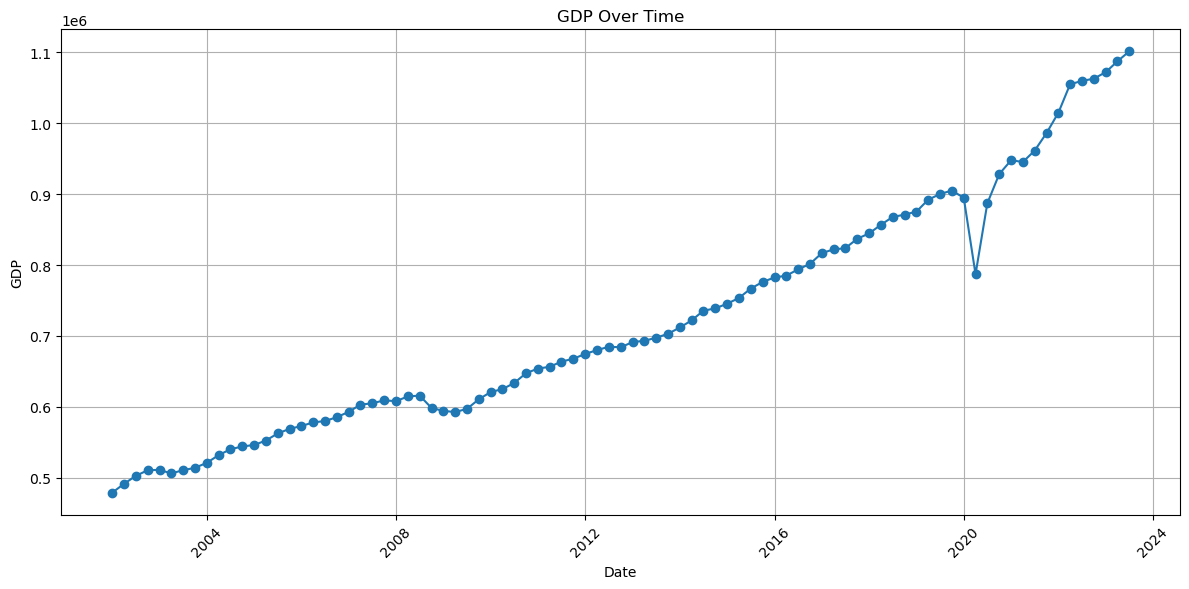

In [85]:
import matplotlib.pyplot as plt

# Plot GDP over time
plt.figure(figsize=(12, 6))
plt.plot(df_gdp.index, df_gdp['GDP'], marker='o', linestyle='-')
plt.title('GDP Over Time')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [86]:
## Remove covid sharp drop in GDP since it is an outlier

covid_start_date = '2020-03-01'
covid_end_date = '2021-03-01'

# Remove data between the start and end dates
df_gdp = df_gdp.loc[~((df_gdp.index >= covid_start_date) & (df_gdp.index < covid_end_date))]

## Calculate the average gain in GDP per year

average_gain = df_gdp['GDP'].diff().mean() 

## Impute the missing values with the average gain in GDP per year

df_gdp['GDP'] = df_gdp['GDP'].fillna(method='ffill') + average_gain


In [87]:
# Step 4: Impute missing values
df_gdp.loc[(df_gdp.index >= covid_start_date) & (df_gdp.index < covid_end_date), 'GDP'] = average_gain

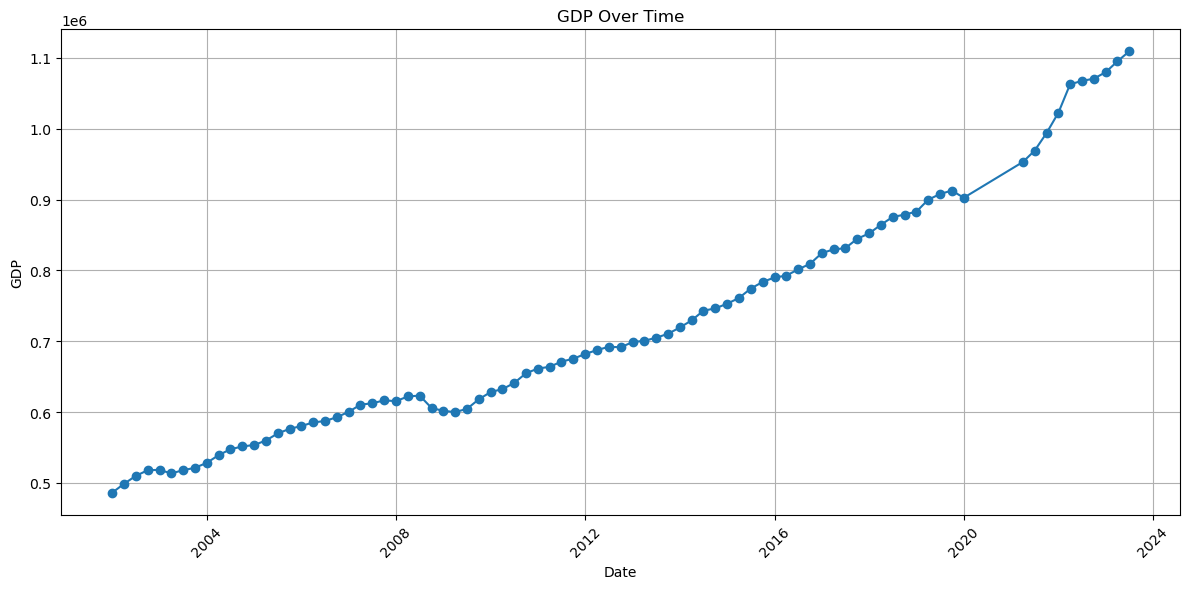

In [88]:
## Visualize the GDP data after imputation
# Plot GDP over time
plt.figure(figsize=(12, 6))
plt.plot(df_gdp.index, df_gdp['GDP'], marker='o', linestyle='-')
plt.title('GDP Over Time')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [89]:
## Check missing values 
df_gdp.isnull().sum()
print(df_gdp.info())    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2002-01-01 to 2023-07-01
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GDP      83 non-null     float64
 1   Quarter  83 non-null     object 
 2   Month    83 non-null     object 
dtypes: float64(1), object(2)
memory usage: 2.6+ KB
None


In [90]:
## Interpolate dataframe to hourly time frame 

## Drop the 'Quarter' and 'Month' columns

df_gdp = df_gdp.drop(columns=['Quarter', 'Month'])

## Resample the DataFrame to hourly frequency and interpolate missing values

df_gdp = df_gdp.resample('H').interpolate(method ='linear')




In [91]:
## View the first few rows of the DataFrame
df_gdp.head(50)



,GDP
Date,
2002-01-01 00:00:00,486347.719512
2002-01-01 01:00:00,486353.444049
2002-01-01 02:00:00,486359.168586
2002-01-01 03:00:00,486364.893123
2002-01-01 04:00:00,486370.617660
2002-01-01 05:00:00,486376.342197
2002-01-01 06:00:00,486382.066734
2002-01-01 07:00:00,486387.791271
2002-01-01 08:00:00,486393.515808


In [ ]:
## Check missing values 
df_gdp.isnull().sum()
print(df_gdp.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188425 entries, 2002-01-01 00:00:00 to 2023-07-01 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   GDP     188425 non-null  float64
dtypes: float64(1)
memory usage: 2.9 MB
None


In [92]:
## Convert the GDP column to float

df_gdp['GDP'] =pd.to_numeric(df_gdp['GDP'], errors='coerce')

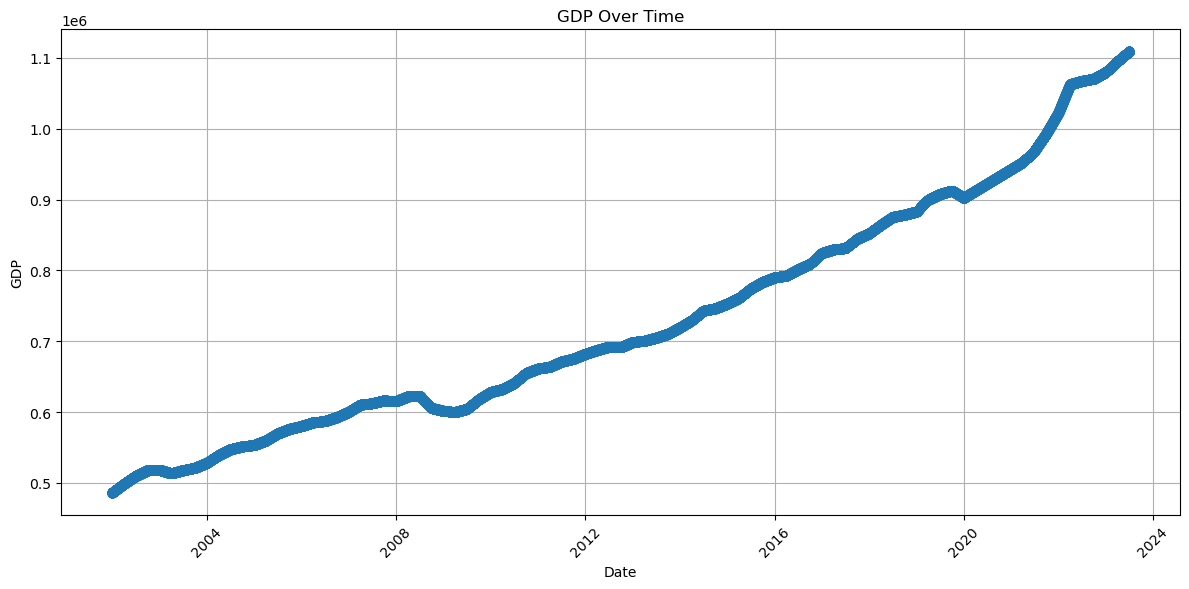

In [93]:
## Plot the GDP data after resampling and interpolation

# Plot GDP over time
plt.figure(figsize=(12, 6))
plt.plot(df_gdp.index, df_gdp['GDP'], marker='o', linestyle='-')
plt.title('GDP Over Time')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [94]:
## Filter gdp data from 2002-05-01 00:00:00 onwards

df_gdp = df_gdp.loc['2002-05-01':]
df_gdp.head()

,GDP
Date,
2002-05-01 00:00:00,502402.719512
2002-05-01 01:00:00,502407.844512
2002-05-01 02:00:00,502412.969512
2002-05-01 03:00:00,502418.094512
2002-05-01 04:00:00,502423.219512


In [95]:
## Reindex GDP dataframe to match demand and price data 

# Reindex the GDP DataFrame to match the date range of the demand and price DataFrames

new_index = pd.date_range(start=df_gdp.index.min(), end='2024-02-22 23:00:00', freq='H')

## Reindex the data frame to include new datae ranges 
df_gdp = df_gdp.reindex(new_index)


## Interpolate missing values using linear interpolation 

df_gdp = df_gdp.interpolate(method='linear')


In [96]:
# Assign a name to the index
df_gdp.index.name = 'Date'

## view the tail and head of the dataframe 

print(df_gdp.head())
print(df_gdp.tail())

                               GDP
Date                              
2002-05-01 00:00:00  502402.719512
2002-05-01 01:00:00  502407.844512
2002-05-01 02:00:00  502412.969512
2002-05-01 03:00:00  502418.094512
2002-05-01 04:00:00  502423.219512
                              GDP
Date                             
2024-02-22 19:00:00  1.109115e+06
2024-02-22 20:00:00  1.109115e+06
2024-02-22 21:00:00  1.109115e+06
2024-02-22 22:00:00  1.109115e+06
2024-02-22 23:00:00  1.109115e+06


In [97]:
# Save the cleaned GDP data to a CSV file in the cleaned data directory
cleaned_gdp_file_path = os.path.join(cleaned_data_dir, 'cleaned_gdp_data.csv')
df_gdp.to_csv(cleaned_gdp_file_path)

print(f"Cleaned GDP data saved to: {cleaned_gdp_file_path}")

Cleaned GDP data saved to: cleaned_data/cleaned_gdp_data.csv


### Population Data 

In [163]:
df_pop = pd.read_csv('ontario_population.csv')

In [164]:
## Check the first few rows of the DataFrame
df_pop.head(10)

,Year,Population,Year on Year Change,Change in Percent
0,2000,"11,216",-,-
1,2001,"11,283",67,0.6%
2,2002,"11,278",-5,-0.04%
3,2003,"11,229",-49,-0.43%
4,2004,"11,178",-51,-0.45%
5,2005,"11,196",18,0.16%
6,2006,"11,199",3,0.03%
7,2007,"11,236",37,0.33%
8,2008,"11,152",-84,-0.75%
9,2009,"11,123",-29,-0.26%


In [165]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Year                 23 non-null     int64 
 1   Population           23 non-null     object
 2   Year on Year Change  23 non-null     object
 3   Change in Percent    23 non-null     object
dtypes: int64(1), object(3)
memory usage: 864.0+ bytes


In [166]:
print(df_pop['Population'].unique())


['11,216' '11,283' '11,278' '11,229' '11,178' '11,196' '11,199' '11,236'
 '11,152' '11,123' '11,373' '11,211' '11,118' '11,097' '11,004' '10,910'
 '10,977' '10,972' '11,039' '11,054' '11,672' '11,671' '11,732']


In [167]:
## Change the Population column to integer

# Remove commas from the 'Population' column
df_pop['Population'] = df_pop['Population'].str.replace(',', '')

# Convert the 'Population' column to numeric
df_pop['Population'] = pd.to_numeric(df_pop['Population'], errors='coerce')





In [168]:
## Make year column a datetime object
df_pop['Year'] = pd.to_datetime(df_pop['Year'], format='%Y')
df_pop.set_index('Year', inplace=True)
df_pop.head(50)


,Population,Year on Year Change,Change in Percent
Year,,,
2000-01-01,11216,-,-
2001-01-01,11283,67,0.6%
2002-01-01,11278,-5,-0.04%
2003-01-01,11229,-49,-0.43%
2004-01-01,11178,-51,-0.45%
2005-01-01,11196,18,0.16%
2006-01-01,11199,3,0.03%
2007-01-01,11236,37,0.33%
2008-01-01,11152,-84,-0.75%


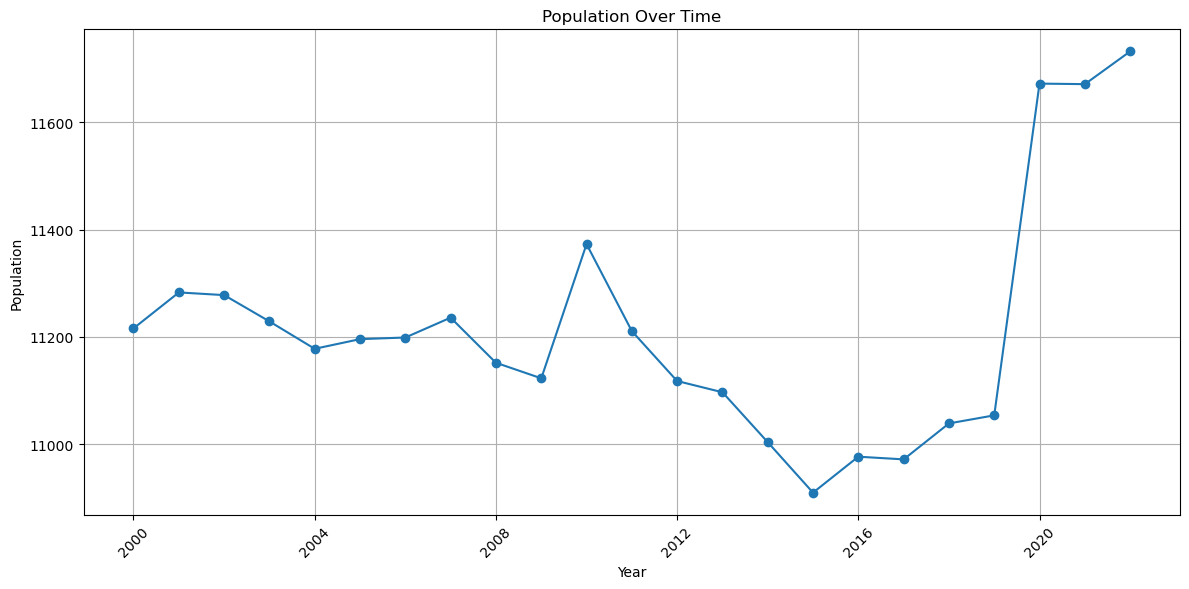

In [169]:
## Plot the population data

# Plot population over time
plt.figure(figsize=(12, 6))
plt.plot(df_pop.index, df_pop['Population'], marker='o', linestyle='-')
plt.title('Population Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [170]:
## Interpolate the population data to hourly time frame

## Resample the DataFrame to hourly frequency and interpolate missing values

## Drop year on year change and change in percent columns 

df_pop = df_pop.drop(columns=['Year on Year Change', 'Change in Percent'])

df_pop = df_pop.resample('H').interpolate(method ='linear')

## View the first few rows of the DataFrame
df_pop.head(50)


,Population
Year,
2000-01-01 00:00:00,11216.000000
2000-01-01 01:00:00,11216.007628
2000-01-01 02:00:00,11216.015255
2000-01-01 03:00:00,11216.022883
2000-01-01 04:00:00,11216.030510
2000-01-01 05:00:00,11216.038138
2000-01-01 06:00:00,11216.045765
2000-01-01 07:00:00,11216.053393
2000-01-01 08:00:00,11216.061020


In [171]:
## Filter population data from 2002-05-01 00:00:00 onwards

df_pop = df_pop.loc['2002-05-01':]
df_pop.head()


,Population
Year,
2002-05-01 00:00:00,11261.890411
2002-05-01 01:00:00,11261.884817
2002-05-01 02:00:00,11261.879224
2002-05-01 03:00:00,11261.873630
2002-05-01 04:00:00,11261.868037


In [179]:
## need to reindex to match demand price data 

##create a new datimeindex for the population data

new_index = pd.date_range(start=df_pop.index.min(), end='2024-02-22 23:00:00', freq='H')

df_pop = df_pop.reindex(new_index)

## Interpolate missing values using linear interpolation

df_pop= df_pop.interpolate(method='linear')

# Assign a name to the index
df_pop.index.name = 'Year'




In [180]:
##view last few rows of the dataframe

df_pop.tail()

,Population
Year,
2024-02-22 19:00:00,11732.0
2024-02-22 20:00:00,11732.0
2024-02-22 21:00:00,11732.0
2024-02-22 22:00:00,11732.0
2024-02-22 23:00:00,11732.0


In [181]:
## Save the cleaned population data to a CSV file in the cleaned data directory

cleaned_population_file_path = os.path.join(cleaned_data_dir, 'cleaned_population_data.csv')
df_pop.to_csv(cleaned_population_file_path)

print(f"Cleaned population data saved to: {cleaned_population_file_path}")

Cleaned population data saved to: cleaned_data/cleaned_population_data.csv


### Demand Data 
**Missing values**   

**Outlier detection**

**Visual inspection**

In [108]:
## Preprocessing Demand data 

## Check the first few rows of the DataFrame
df_d = pd.read_csv('raw_data/raw_dem_data.csv')
df_d.head(10)


,DateTime,Market Demand,Ontario Demand
0,2002-05-01 00:00:00,14141,14137
1,2002-05-01 01:00:00,13876,13872
2,2002-05-01 02:00:00,13974,13820
3,2002-05-01 03:00:00,13898,13744
4,2002-05-01 04:00:00,14378,14224
5,2002-05-01 05:00:00,15408,15404
6,2002-05-01 06:00:00,17070,17066
7,2002-05-01 07:00:00,17644,17640
8,2002-05-01 08:00:00,17723,17719
9,2002-05-01 09:00:00,17774,17770


In [109]:
df_d.tail()

,DateTime,Market Demand,Ontario Demand
190365,2024-02-22 18:00:00,18881,17863
190366,2024-02-22 19:00:00,18812,17991
190367,2024-02-22 20:00:00,18816,17636
190368,2024-02-22 21:00:00,18522,17138
190369,2024-02-22 22:00:00,17718,16265


In [110]:
## Info 
print(df_d.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190370 entries, 0 to 190369
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   DateTime        190370 non-null  object
 1   Market Demand   190370 non-null  int64 
 2   Ontario Demand  190370 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB
None


In [111]:
## Change Datetime column to datetime object and drop Market Demand column

df_d['DateTime'] = pd.to_datetime(df_d['DateTime'])
df_d = df_d.drop(columns=['Market Demand'])

## Set the 'DateTime' column as the index
df_d.set_index('DateTime', inplace=True)

## Check the first few rows of the DataFrame
df_d.head(10)


,Ontario Demand
DateTime,
2002-05-01 00:00:00,14137
2002-05-01 01:00:00,13872
2002-05-01 02:00:00,13820
2002-05-01 03:00:00,13744
2002-05-01 04:00:00,14224
2002-05-01 05:00:00,15404
2002-05-01 06:00:00,17066
2002-05-01 07:00:00,17640
2002-05-01 08:00:00,17719


In [112]:
## Check missing values and info

df_d.isnull().sum()
print(df_d.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 190370 entries, 2002-05-01 00:00:00 to 2024-02-22 22:00:00
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   Ontario Demand  190370 non-null  int64
dtypes: int64(1)
memory usage: 2.9 MB
None


In [113]:
df_d['Ontario Demand'].describe()

count    190370.000000
mean      16225.700657
std        2583.007317
min        2270.000000
25%       14290.000000
50%       16119.000000
75%       18011.000000
max       27005.000000
Name: Ontario Demand, dtype: float64

- The mean demand is approximately 16,225 MW, with a standard deviation of 2,583 MW, indicating variability in the demand values around the mean.
- The minimum demand observed is 2,270 MW, while the maximum demand recorded is 27,005 MW.
- The interquartile range (IQR), which represents the middle 50% of the data, spans from 14,289 MW to 18,012 MW.
- The median demand (50th percentile) is 16,118 MW, which is close to the mean demand, suggesting a relatively symmetric distribution.
- There is a noticeable difference between the 75th percentile (18,012 MW) and the maximum demand (27,005 MW), indicating the presence of potential outliers in the upper tail of the distribution.


<AxesSubplot:ylabel='Frequency'>

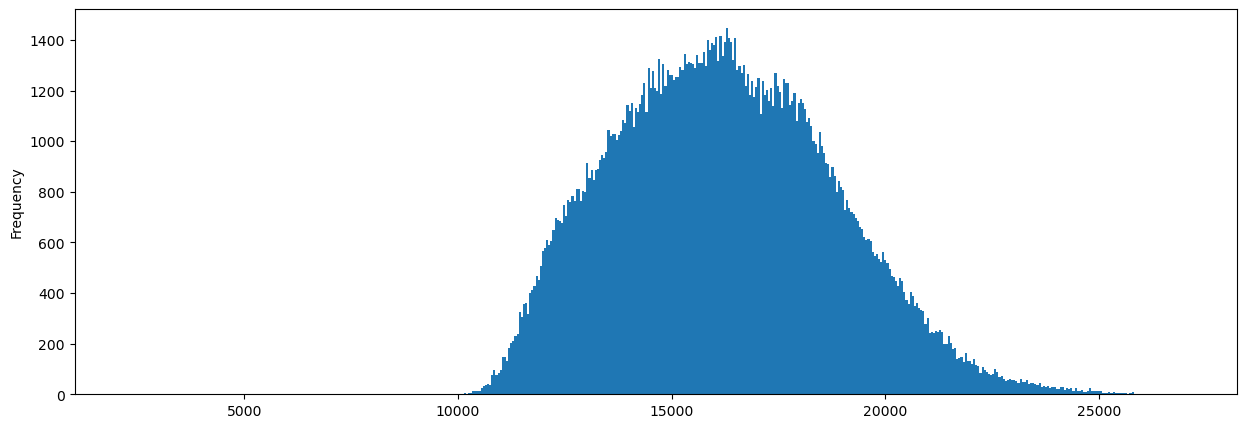

In [114]:
df_d['Ontario Demand'].plot(kind = 'hist', bins=500, figsize = (15,5))

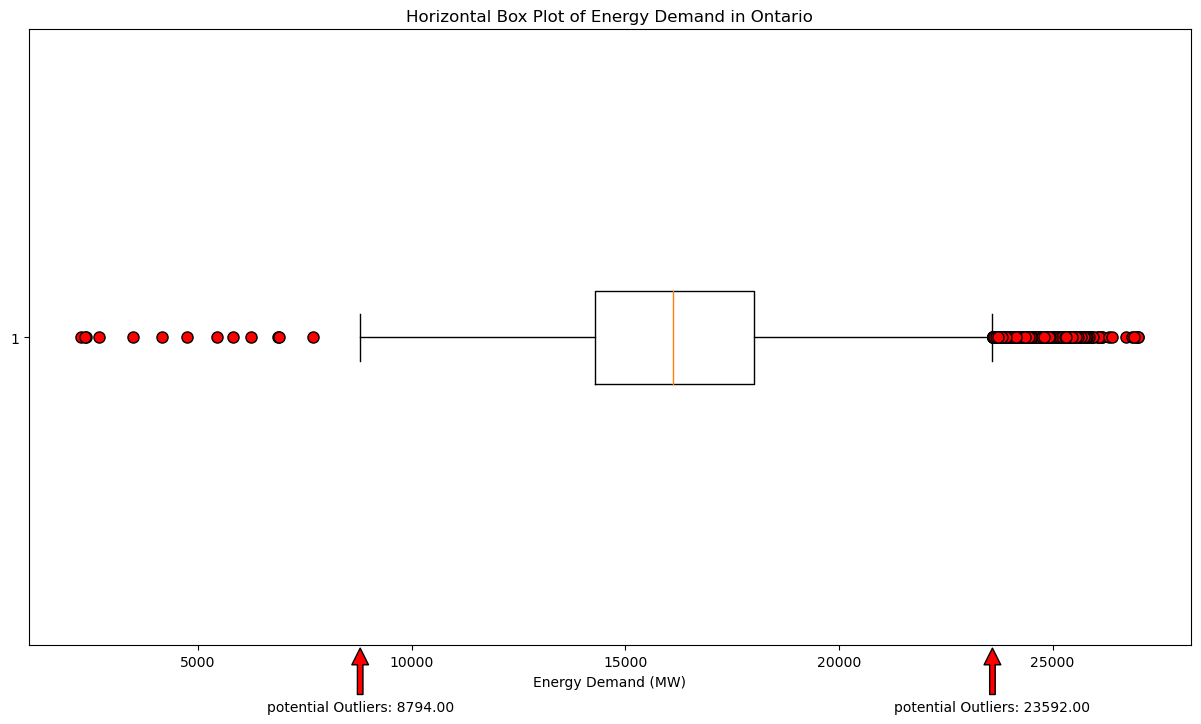

In [115]:
## 

# Assuming df is your DataFrame with the 'PJME_MW' column
data = df_d['Ontario Demand']

# Create a larger horizontal box plot
plt.figure(figsize=(15, 8))
boxplot = plt.boxplot(data, vert=False, flierprops=dict(marker='o', markerfacecolor='red', markersize=8))

# You can also set additional properties like labels and title if needed
plt.xlabel('Energy Demand (MW)')
plt.title('Horizontal Box Plot of Energy Demand in Ontario')

# Extract the x-values of the left and right whiskers
whisker_left = boxplot['whiskers'][0].get_xdata()
whisker_right = boxplot['whiskers'][1].get_xdata()

# Mark the position of the ends of both whiskers on the plot
plt.annotate(f'potential Outliers: {whisker_left[1]:.2f}', xy=(whisker_left[1], 0.5), xytext=(whisker_left[1], 0.4),
             arrowprops=dict(facecolor='red', shrink=0.05), ha='center', va='center')

plt.annotate(f'potential Outliers: {whisker_right[1]:.2f}', xy=(whisker_right[1], 0.5), xytext=(whisker_right[1], 0.4),
             arrowprops=dict(facecolor='red', shrink=0.05), ha='center', va='center')

# Show the plot
plt.show()



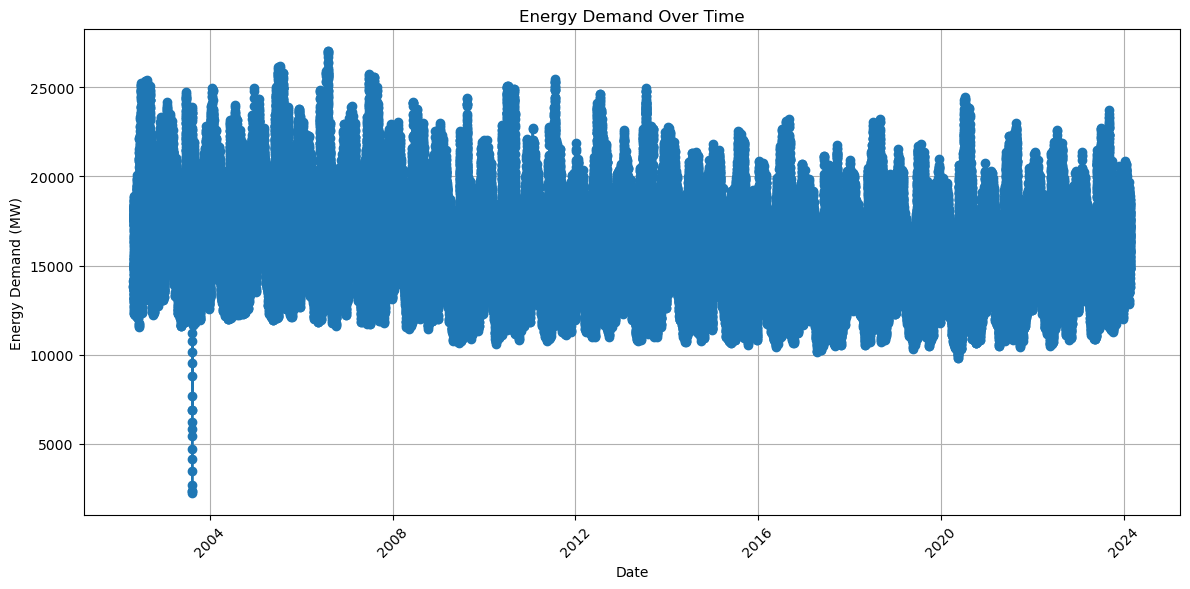

In [116]:
## Visual inspection of the data 

# Plot energy demand over time
plt.figure(figsize=(12, 6))
plt.plot(df_d.index, df_d['Ontario Demand'], marker='o', linestyle='-')
plt.title('Energy Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Demand (MW)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




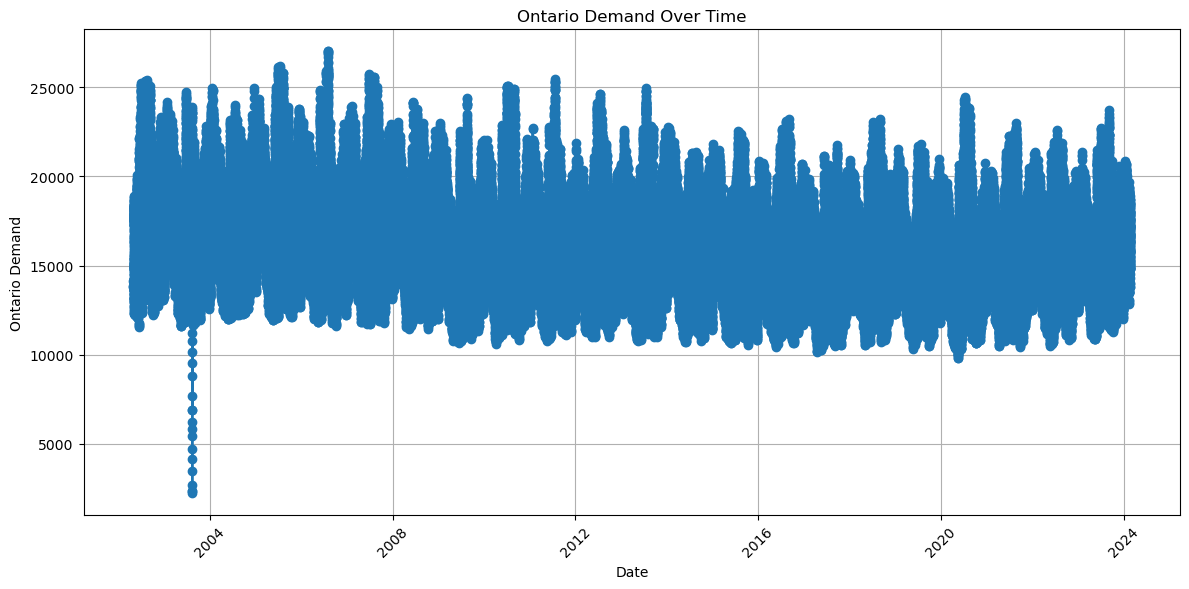

In [117]:
## Plot ontario demand over time 

# Plot Ontario demand over time

plt.figure(figsize=(12, 6))
plt.plot(df_d.index, df_d['Ontario Demand'], marker='o', linestyle='-')
plt.title('Ontario Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Ontario Demand')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



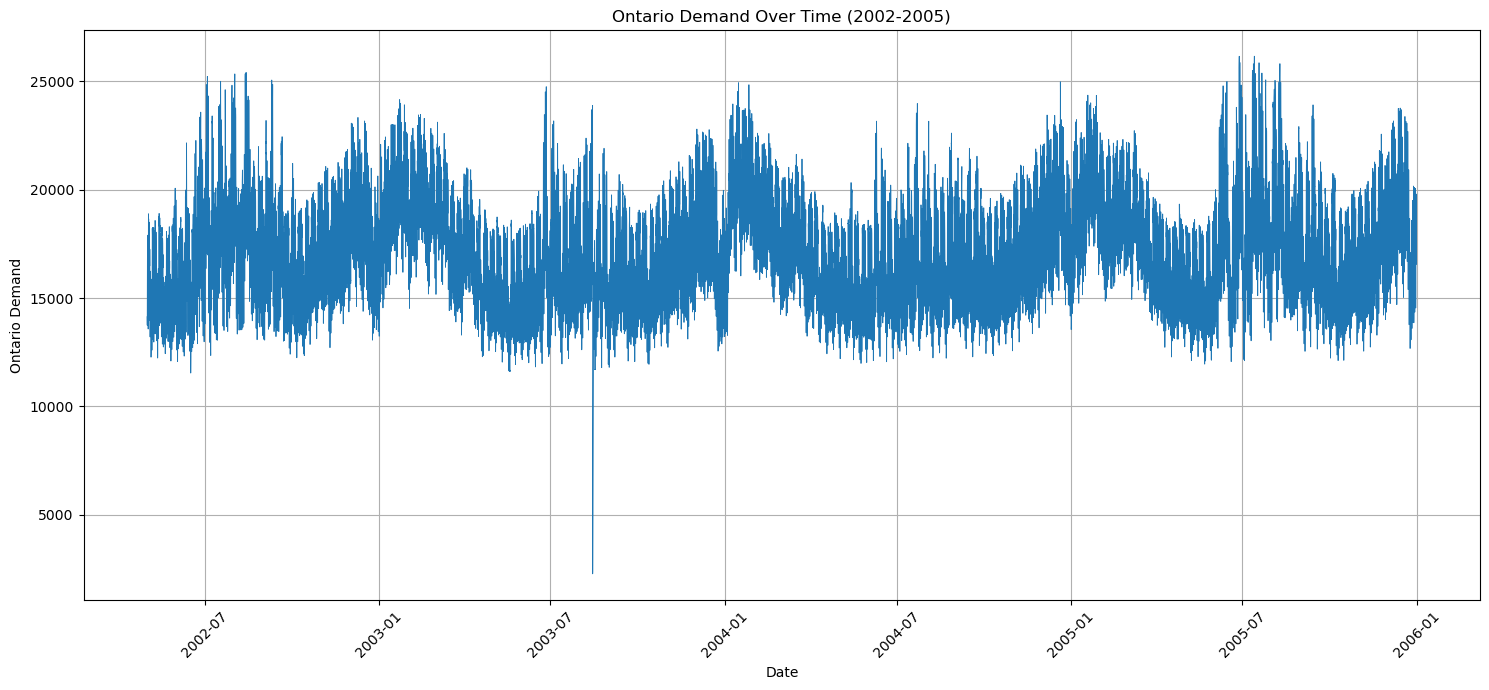

In [118]:
## closer look from 2002 to 2005

# Plot Ontario demand over time from 2002 to 2005   
plt.figure(figsize=(15, 7))
plt.plot(df_d.loc['2002':'2005'].index, df_d.loc['2002':'2005']['Ontario Demand'], linewidth=0.6)
plt.title('Ontario Demand Over Time (2002-2005)')
plt.xlabel('Date')
plt.ylabel('Ontario Demand')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



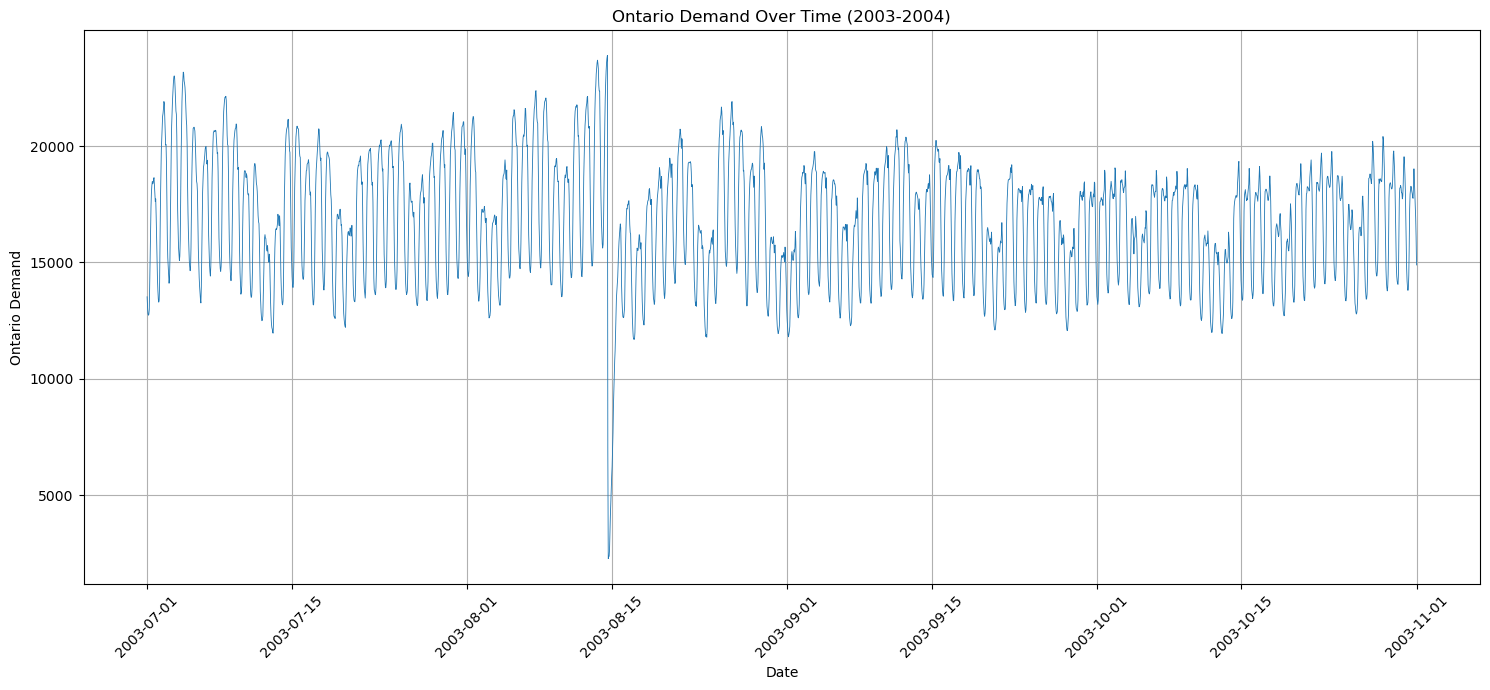

In [119]:

# Plot Ontario demand over time from 2002 to 2005   
plt.figure(figsize=(15, 7))
plt.plot(df_d.loc['2003-07':'2003-10'].index, df_d.loc['2003-07':'2003-10']['Ontario Demand'], linewidth=0.6)
plt.title('Ontario Demand Over Time (2003-2004)')
plt.xlabel('Date')
plt.ylabel('Ontario Demand')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [120]:
## Replace outliers with the mean of the dataset 

# Calculate the mean of the 'Ontario Demand' column

demand_mean = df_d['Ontario Demand'].mean()


# Replace outliers with nan 

df_d.loc[df_d['Ontario Demand']<10000, 'Ontario Demand'] = np.nan

# Fill missing values with the mean

df_d['Ontario Demand'] = df_d['Ontario Demand'].fillna(demand_mean)


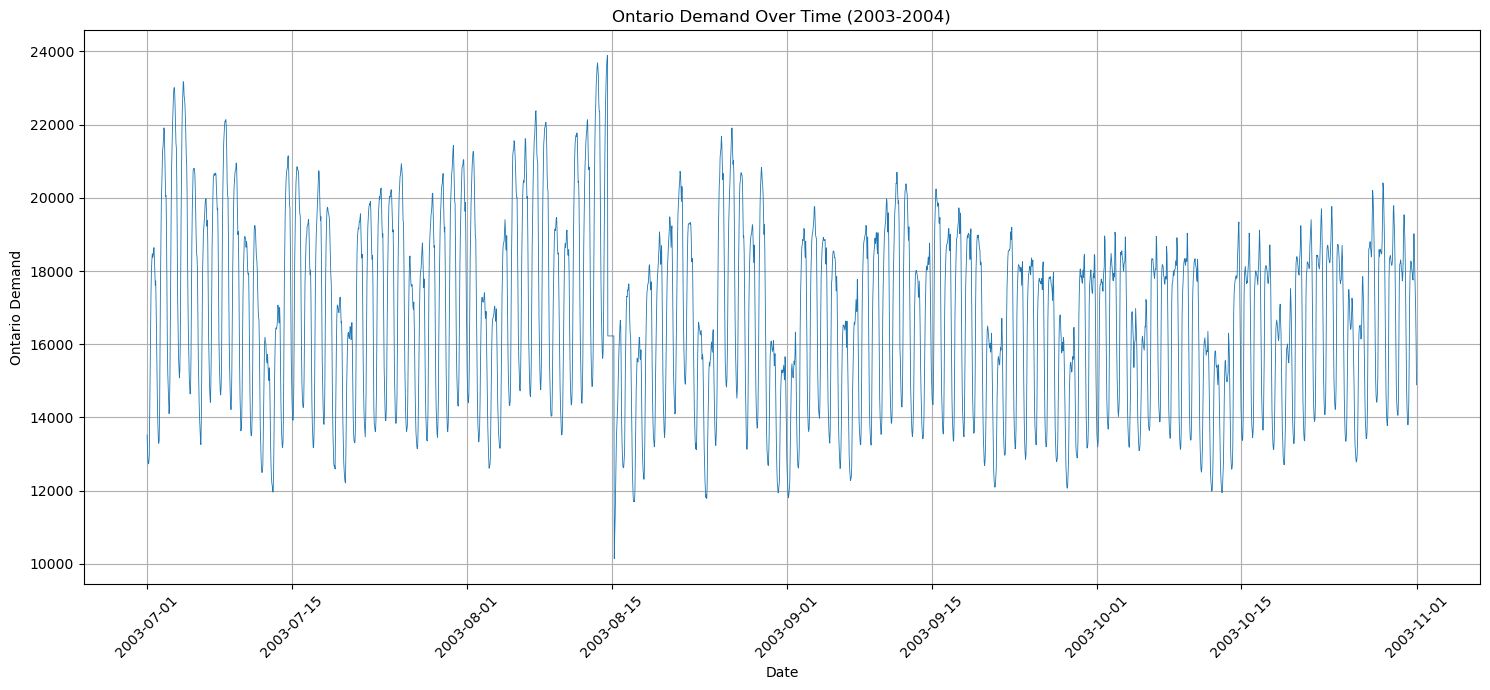

In [121]:

# Plot Ontario demand over time from 2002 to 2005   
plt.figure(figsize=(15, 7))
plt.plot(df_d.loc['2003-07':'2003-10'].index, df_d.loc['2003-07':'2003-10']['Ontario Demand'], linewidth=0.6)
plt.title('Ontario Demand Over Time (2003-2004)')
plt.xlabel('Date')
plt.ylabel('Ontario Demand')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

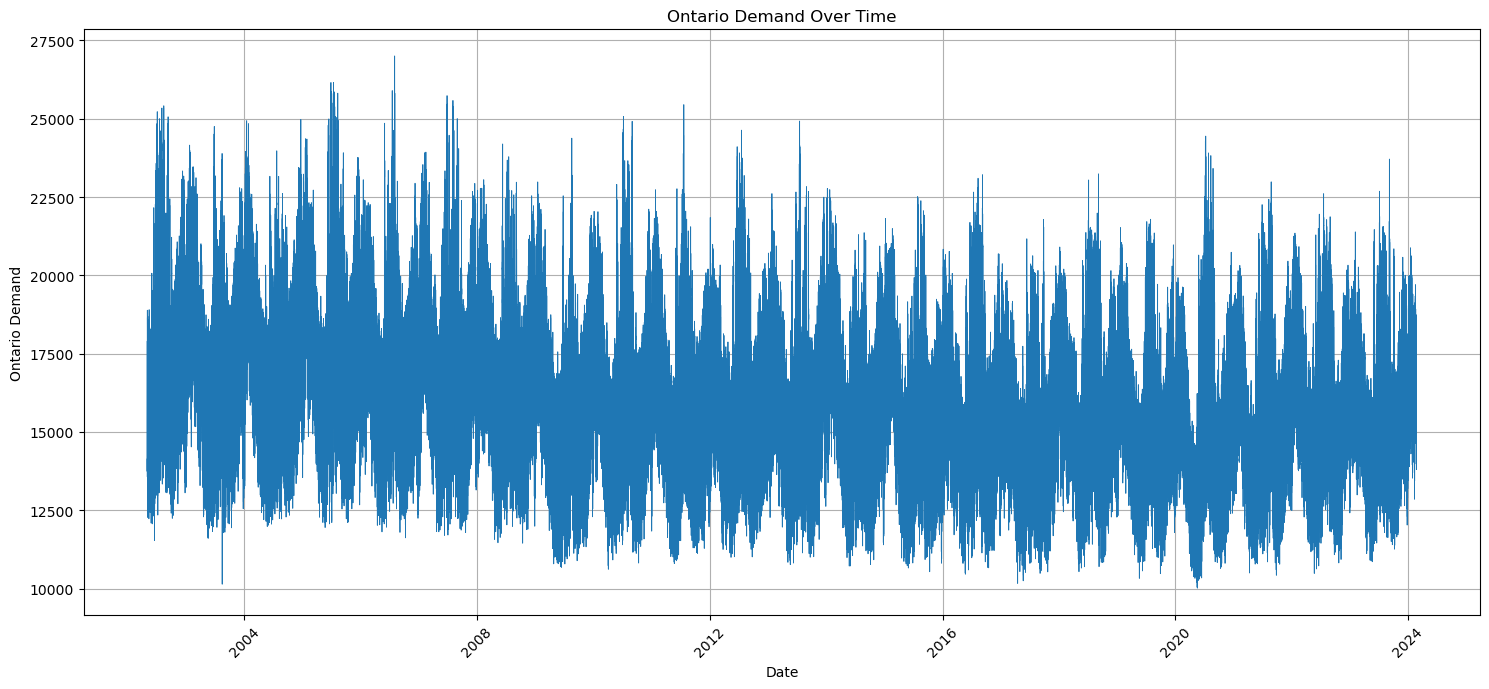

In [122]:
## View full data set after replacing outliers

# Plot Ontario demand over time
plt.figure(figsize=(15, 7))
plt.plot(df_d.index, df_d['Ontario Demand'], linewidth=0.6)
plt.title('Ontario Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Ontario Demand')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [123]:
## Save the cleaned population data to a CSV file in the cleaned data directory

cleaned_demand_file_path = os.path.join(cleaned_data_dir, 'cleaned_demand_data.csv')
df_d.to_csv(cleaned_demand_file_path)

print(f"Cleaned demand data saved to: {cleaned_demand_file_path}")

Cleaned population data saved to: cleaned_data/cleaned_demand_data.csv


### Price Data 
**Missing values**   

**Outlier detection**

**Visual inspection**

In [124]:
## Import Raw Price Data 

df_price = pd.read_csv('raw_data/raw_price_data.csv')
pd.set_option('display.max_rows', None)
df_price.head(10)   

/var/folders/vr/r8mf2bqs5rq239fpzg2_n3z00000gn/T/ipykernel_70349/136882482.py:3: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_price = pd.read_csv('raw_data/raw_price_data.csv')


,DateTime,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
0,2002-05-01 00:00:00,22.97,14.53,14.53,14.53,NaN,NaN,NaN
1,2002-05-01 01:00:00,23.27,21.31,21.37,21.37,NaN,NaN,NaN
2,2002-05-01 02:00:00,24.54,25.45,21.38,21.38,NaN,NaN,NaN
3,2002-05-01 03:00:00,15.17,24.92,24.92,14.53,NaN,NaN,NaN
4,2002-05-01 04:00:00,23.59,27.38,27.38,27.4,NaN,NaN,NaN
5,2002-05-01 05:00:00,28.84,30.34,30.18,30.18,NaN,NaN,NaN
6,2002-05-01 06:00:00,30.63,30.78,30.78,30.49,NaN,NaN,NaN
7,2002-05-01 07:00:00,32.23,30.92,30.92,30.92,NaN,NaN,NaN
8,2002-05-01 08:00:00,30.00,30.22,30.73,30.73,NaN,NaN,NaN
9,2002-05-01 09:00:00,30.16,30.3,30.24,30.75,NaN,NaN,NaN


In [125]:
## HOEP data and date 
df_price = df_price.iloc[:, :2]
df_price.head(10)


,DateTime,HOEP
0,2002-05-01 00:00:00,22.97
1,2002-05-01 01:00:00,23.27
2,2002-05-01 02:00:00,24.54
3,2002-05-01 03:00:00,15.17
4,2002-05-01 04:00:00,23.59
5,2002-05-01 05:00:00,28.84
6,2002-05-01 06:00:00,30.63
7,2002-05-01 07:00:00,32.23
8,2002-05-01 08:00:00,30.00
9,2002-05-01 09:00:00,30.16


In [126]:
## Check column data types and missing values
print(df_price.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191232 entries, 0 to 191231
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   DateTime  191232 non-null  object 
 1   HOEP      191224 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.9+ MB
None


In [127]:
## Convert the 'Date' column to datetime object
df_price['DateTime'] = pd.to_datetime(df_price['DateTime'])


## Set the 'DateTime' column as the index
df_price.set_index('DateTime', inplace=True)

## Convert HOEP to float 
df_price['HOEP'] = pd.to_numeric(df_price['HOEP'], errors='coerce')

## Check the first few rows of the DataFrame

df_price.head(10)

,HOEP
DateTime,
2002-05-01 00:00:00,22.97
2002-05-01 01:00:00,23.27
2002-05-01 02:00:00,24.54
2002-05-01 03:00:00,15.17
2002-05-01 04:00:00,23.59
2002-05-01 05:00:00,28.84
2002-05-01 06:00:00,30.63
2002-05-01 07:00:00,32.23
2002-05-01 08:00:00,30.00


In [129]:
df_2017 = pd.DataFrame(df_price.loc['2017'])
df_2017.sort_values(by='DateTime', inplace=True)
df_2017.head()

,HOEP
DateTime,
2017-01-01 00:00:00,0.0
2017-01-01 01:00:00,0.0
2017-01-01 02:00:00,0.0
2017-01-01 03:00:00,0.0
2017-01-01 04:00:00,0.0


In [130]:
## Check missing values and info

df_price.isnull().sum()
print(df_price.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191232 entries, 2002-05-01 00:00:00 to 2024-02-22 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   HOEP    191224 non-null  float64
dtypes: float64(1)
memory usage: 2.9 MB
None


In [131]:
df_price['HOEP'].describe()

count    191224.000000
mean         33.613898
std          32.234876
min        -138.790000
25%          14.430000
50%          29.750000
75%          42.520000
max        1660.800000
Name: HOEP, dtype: float64

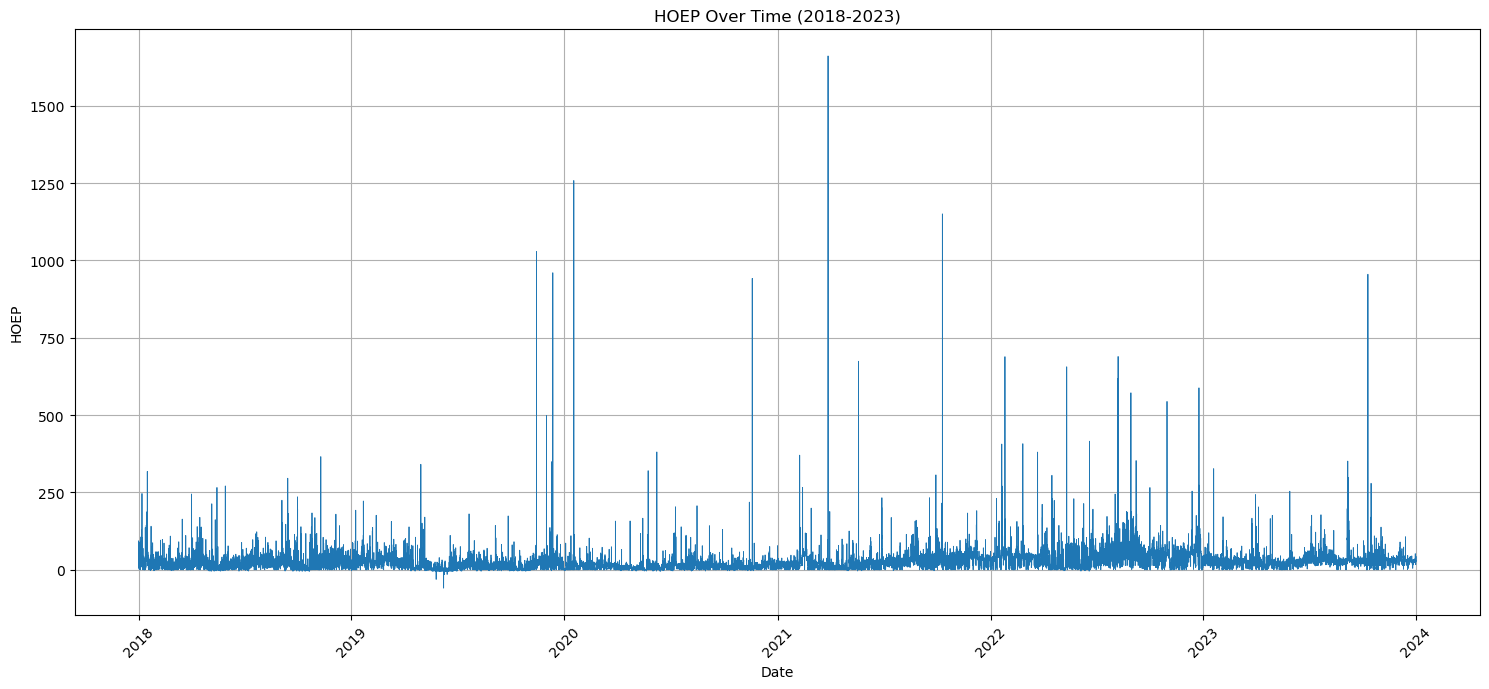

In [132]:
## Want to see data from 2018 to 2023

# Plot HOEP over time from 2018 to 2023

plt.figure(figsize=(15, 7))
plt.plot(df_price.loc['2018':'2023'].index, df_price.loc['2018':'2023']['HOEP'], linewidth=0.6)
plt.title('HOEP Over Time (2018-2023)')
plt.xlabel('Date')
plt.ylabel('HOEP')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

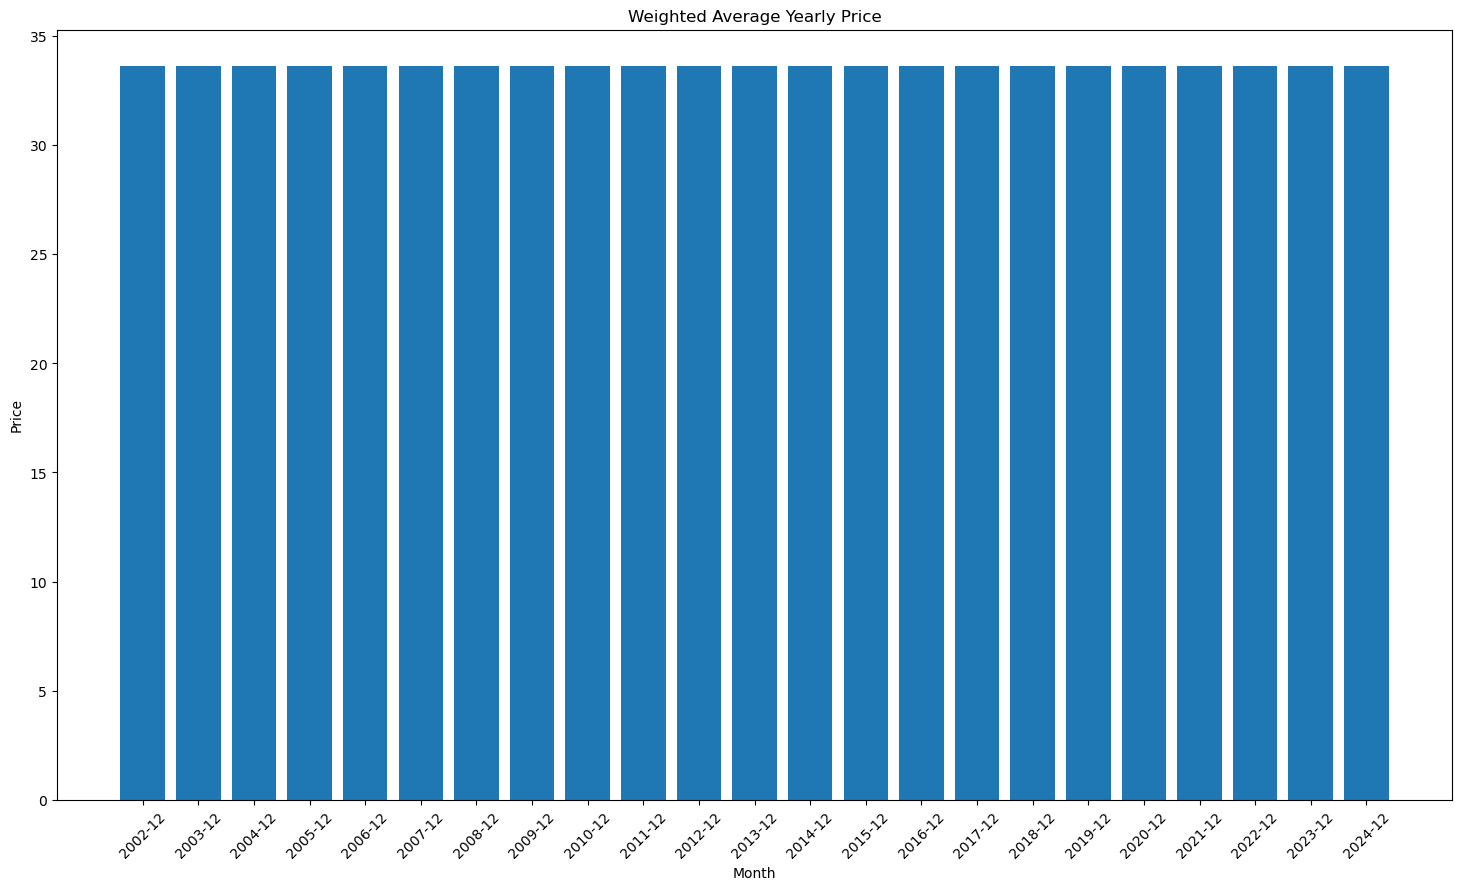

In [133]:
import pandas as pd

## Finding weighted hourly y
# Resample to monthly frequency
df_monthly = df_price.resample('Y').mean()

# Calculate the number of hours in each month
hours_in_year = df_price.resample('Y').size()

# Calculate the product of price and hours
product = df_monthly['HOEP'] * hours_in_year

# Calculate the weighted average monthly price
weighted_avg_yearly_price = product.sum() / hours_in_year.sum()

# Plot the weighted average monthly price
import matplotlib.pyplot as plt

# list of Years for plotting
months = df_monthly.index.strftime('%Y-%m')

plt.figure(figsize=(18,10))
plt.bar(months, [weighted_avg_yearly_price] * len(months))
plt.title('Weighted Average Yearly Price')
plt.xlabel('Month')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()


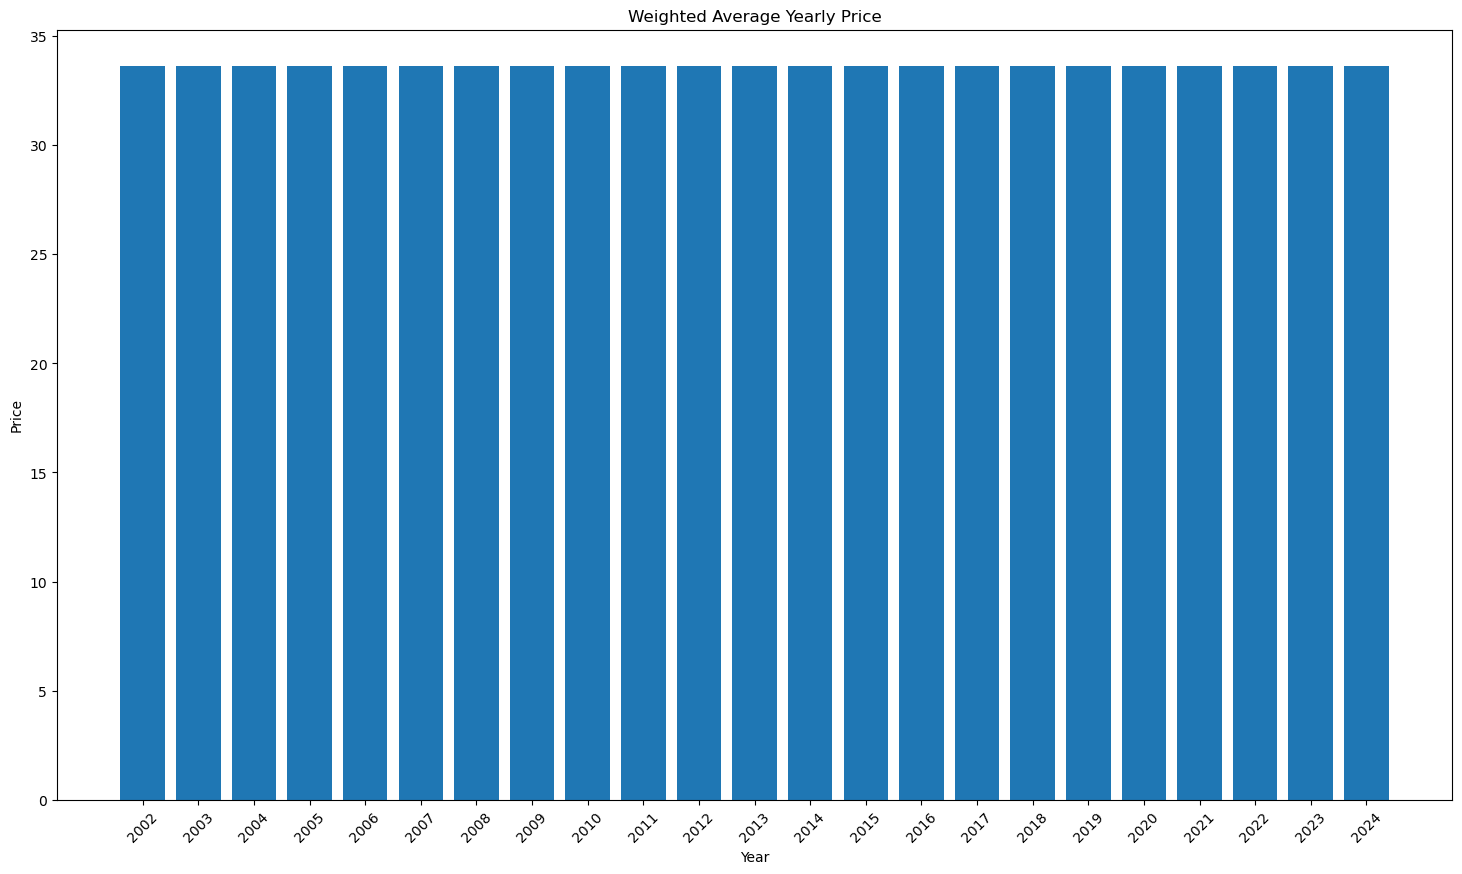

In [ ]:
## Calculates the weighted yearly average price for each year and plot it 

# Resample to yearly frequency
df_yearly = df_price.resample('Y').mean()

# Calculate the number of hours in each year
hours_in_year = df_price.resample('Y').size()

# Calculate the product of price and hours
product = df_yearly['HOEP'] * hours_in_year

# Calculate the weighted average yearly price
weighted_avg_yearly_price = product.sum() / hours_in_year.sum()

# Plot the weighted average yearly price
import matplotlib.pyplot as plt

# list of Years for plotting
years = df_yearly.index.strftime('%Y')

plt.figure(figsize=(18,10))
plt.bar(years, [weighted_avg_yearly_price] * len(years))
plt.title('Weighted Average Yearly Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()





In [134]:
# Resample the DataFrame to monthly frequency
monthly_prices = df_price.resample('M').mean()
print(monthly_prices)

# Calculate the number of days in each month
days_in_month = df_price.resample('M').size()
print(days_in_month)

# Calculate the weighted average monthly price
weighted_avg = (monthly_prices * days_in_month).sum(axis=1) / days_in_month.sum()
print(weighted_avg)




                 HOEP
DateTime             
2002-05-31  29.192110
2002-06-30  35.133806
2002-07-31  58.097298
2002-08-31  64.183441
2002-09-30  73.867218
2002-10-31  48.655336
2002-11-30  49.375597
2002-12-31  56.272204
2003-01-31  59.617970
2003-02-28  86.457054
2003-03-31  81.494570
2003-04-30  58.883292
2003-05-31  43.165444
2003-06-30  41.635625
2003-07-31  40.078884
2003-08-31  48.966626
2003-09-30  48.556861
2003-10-31  57.091935
2003-11-30  40.453764
2003-12-31  44.419852
2004-01-31  66.217648
2004-02-29  52.743276
2004-03-31  48.899960
2004-04-30  45.923583
2004-05-31  48.061828
2004-06-30  46.687333
2004-07-31  45.584207
2004-08-31  43.505591
2004-09-30  49.567292
2004-10-31  49.112796
2004-11-30  52.278889
2004-12-31  50.821465
2005-01-31  57.904220
2005-02-28  49.584717
2005-03-31  59.872957
2005-04-30  61.925611
2005-05-31  53.047460
2005-06-30  65.993444
2005-07-31  76.054126
2005-08-31  88.244435
2005-09-30  93.699389
2005-10-31  75.916586
2005-11-30  58.254944
2005-12-31

In [135]:
# Filter out months with zero prices
monthly_prices = monthly_prices[monthly_prices['HOEP'] != 0]

# Recalculate the number of days in each month
days_in_month = monthly_prices.index.to_period('M').value_counts()

# Calculate the weighted average monthly price
weighted_avg = (monthly_prices['HOEP'] * days_in_month).sum() / days_in_month.sum()

print(weighted_avg)


0.0


/var/folders/vr/r8mf2bqs5rq239fpzg2_n3z00000gn/T/ipykernel_70349/333857918.py:8: RuntimeWarning: '<' not supported between instances of 'Period' and 'Timestamp', sort order is undefined for incomparable objects.
  weighted_avg = (monthly_prices['HOEP'] * days_in_month).sum() / days_in_month.sum()


In [136]:



# Select a specific year from your DataFrame (e.g., 2002)
df_2002 = df_price['2002']

# Calculate the number of hours in 2002
hours_in_2002 = len(df_2002)

# Calculate the product of price and hours for 2002
product_2002 = df_2002['HOEP'].sum()

# Calculate the weighted average yearly price for 2002
weighted_avg_yearly_price_2002 = product_2002 / hours_in_2002

print("Weighted Average Yearly Price for 2002:", weighted_avg_yearly_price_2002)


Weighted Average Yearly Price for 2002: 51.82299149659864


/var/folders/vr/r8mf2bqs5rq239fpzg2_n3z00000gn/T/ipykernel_70349/3073917643.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_2002 = df_price['2002']


In [137]:
weighted_avg_yearly_prices = []

# Iterate over each year in the DataFrame

for year in df_price.index.year.unique():

    # Select data for the current year
    df_year = df_price[str(year)]

    # Calculate the number of hours in the current year
    hours_in_year = len(df_year)

    # Calculate the product of price and hours for the current year
    product_year = df_year['HOEP'].sum()

    # Calculate the weighted average yearly price for the current year
    weighted_avg_yearly_price = product_year / hours_in_year

    # Append the weighted average yearly price to the list
    weighted_avg_yearly_prices.append(weighted_avg_yearly_price)

/var/folders/vr/r8mf2bqs5rq239fpzg2_n3z00000gn/T/ipykernel_70349/2278894724.py:8: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_year = df_price[str(year)]


In [138]:
import pandas as pd

# Assuming df_price is your DataFrame with datetime index and price data

# Initialize a list to store the results
weighted_avg_yearly_prices = []

# Iterate over each year from 2002 to 2024
for year in range(2002, 2025):
    # Select data for the current year
    df_year = df_price[str(year)]

    # Calculate the number of hours in the current year
    hours_in_year = len(df_year)

    # Calculate the product of price and hours for the current year
    product_year = df_year['HOEP'].sum()

    # Calculate the weighted average yearly price for the current year
    weighted_avg_yearly_price = product_year / hours_in_year

    # Append the year and the corresponding weighted average price to the list
    weighted_avg_yearly_prices.append((year, weighted_avg_yearly_price))

# Print the list of yearly weighted average prices
print(weighted_avg_yearly_prices)


[(2002, 51.82299149659864), (2003, 54.045417808219185), (2004, 49.9496618852459), (2005, 68.49205365296804), (2006, 46.38307648401826), (2007, 47.806318493150684), (2008, 48.82963342440802), (2009, 29.182849315068495), (2010, 36.25396347031963), (2011, 30.15176141552511), (2012, 22.804873633879783), (2013, 24.97847146118722), (2014, 32.38841780821918), (2015, 21.24026369863014), (2016, 14.899043715846995), (2017, 13.73486301369863), (2018, 22.444434931506848), (2019, 16.715850456621006), (2020, 12.651440118397085), (2021, 26.74762671232877), (2022, 44.95761415525114), (2023, 28.569253424657536), (2024, 36.80667452830189)]


/var/folders/vr/r8mf2bqs5rq239fpzg2_n3z00000gn/T/ipykernel_70349/1733306400.py:11: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_year = df_price[str(year)]


In [139]:
weighted_avg_yearly_prices

[(2002, 51.82299149659864),
 (2003, 54.045417808219185),
 (2004, 49.9496618852459),
 (2005, 68.49205365296804),
 (2006, 46.38307648401826),
 (2007, 47.806318493150684),
 (2008, 48.82963342440802),
 (2009, 29.182849315068495),
 (2010, 36.25396347031963),
 (2011, 30.15176141552511),
 (2012, 22.804873633879783),
 (2013, 24.97847146118722),
 (2014, 32.38841780821918),
 (2015, 21.24026369863014),
 (2016, 14.899043715846995),
 (2017, 13.73486301369863),
 (2018, 22.444434931506848),
 (2019, 16.715850456621006),
 (2020, 12.651440118397085),
 (2021, 26.74762671232877),
 (2022, 44.95761415525114),
 (2023, 28.569253424657536),
 (2024, 36.80667452830189)]

In [140]:
import pandas as pd

# List of tuples containing year and weighted average yearly price
yearly_prices = weighted_avg_yearly_prices

# Convert the list of tuples into a DataFrame
df_yearly_prices = pd.DataFrame(yearly_prices, columns=['Year', 'Weighted_Avg_Price'])

# Set the 'Year' column as the index
df_yearly_prices.set_index('Year', inplace=True)

# Display the DataFrame
df_yearly_prices.head(22)


,Weighted_Avg_Price
Year,
2002,51.822991
2003,54.045418
2004,49.949662
2005,68.492054
2006,46.383076
2007,47.806318
2008,48.829633
2009,29.182849
2010,36.253963


In [141]:
## Find the mean of the weighted average yearly price

# Calculate the mean of the weighted average yearly price

mean_weighted_avg_yearly_price = df_yearly_prices['Weighted_Avg_Price'].mean()
mean_weighted_avg_yearly_price

33.9937632653934

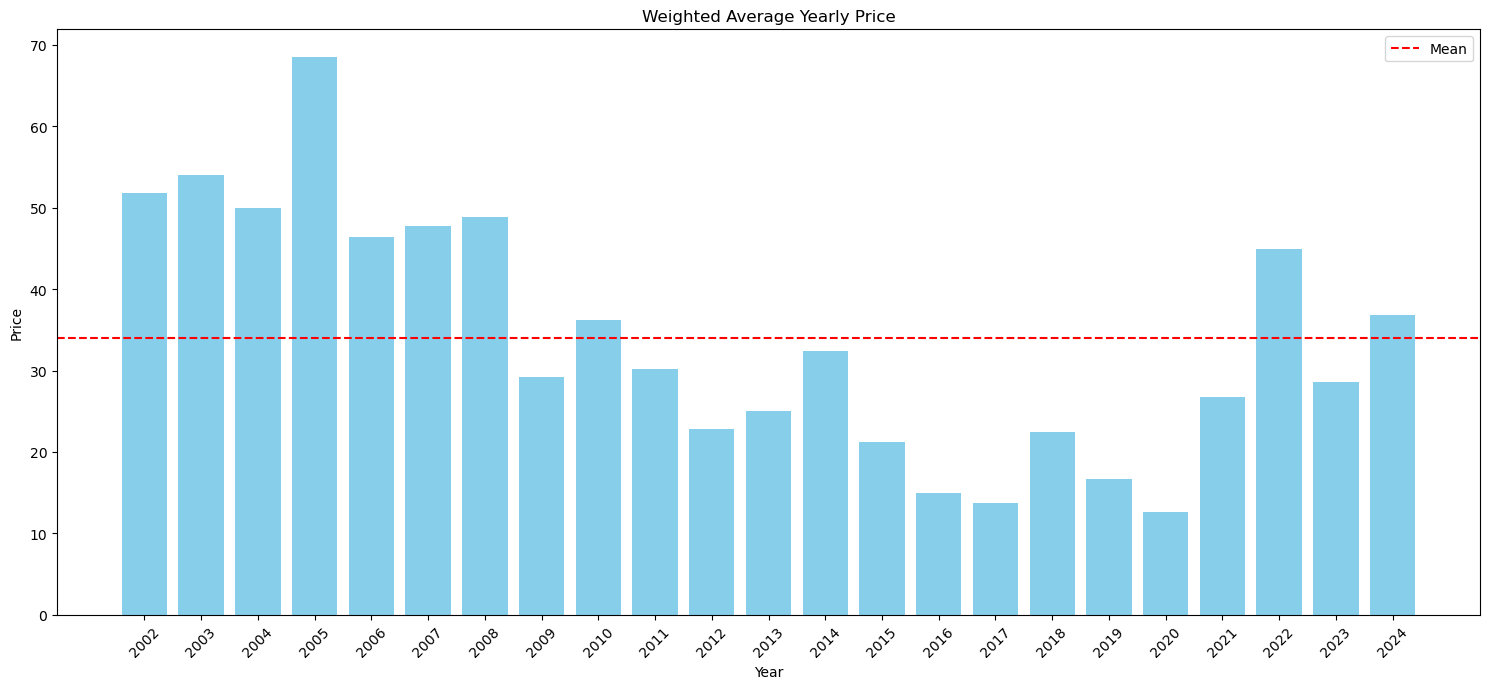

In [142]:
## Plot the weighted average yearly price as a bar plot, and plot the mean as a horizontal line

# Plot the weighted average yearly price as a bar plot

plt.figure(figsize=(15, 7))
plt.bar(df_yearly_prices.index, df_yearly_prices['Weighted_Avg_Price'], color='skyblue')
plt.axhline(mean_weighted_avg_yearly_price, color='red', linestyle='--', label='Mean')
plt.title('Weighted Average Yearly Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.xticks(df_yearly_prices.index, rotation=45)  # Set the tick labels to be the index (years)
plt.tight_layout()
plt.show()



**This matches the IESO monthly price report and no missing values. It is ready for modeling**

In [143]:
cleaned_price_file_path = os.path.join(cleaned_data_dir, 'cleaned_price_data.csv')
df_price.to_csv(cleaned_price_file_path)

print(f"Cleaned price data saved to: {cleaned_price_file_path}")

Cleaned price data saved to: cleaned_data/cleaned_price_data.csv


## Merge all data into a single data frame on datetime index 

* Demand 
* Price
* Population 
* GDP
* Holidays 
* Weather (Will be added in iteration 2)

In [182]:
## Load all cleaned CSV files and merge them into a single DataFrame

# Load the cleaned demand data
df_d = pd.read_csv('cleaned_data/cleaned_demand_data.csv', parse_dates=True, index_col='DateTime')

# Load the cleaned price data
df_price = pd.read_csv('cleaned_data/cleaned_price_data.csv', parse_dates=True, index_col='DateTime')

# Load the cleaned population data
df_pop = pd.read_csv('cleaned_data/cleaned_population_data.csv', parse_dates=True, index_col='Year')

# Load the cleaned GDP data
df_gdp = pd.read_csv('cleaned_data/cleaned_gdp_data.csv', parse_dates=True, index_col='Date')

# Load the cleaned holiday data
df_holidays = pd.read_csv('cleaned_data/holiday_data.csv', parse_dates=True, index_col='DateTime')

# Display the first few rows of the demand data
print("Demand Data:")
print(df_d.head())

# Display the first few rows of the price data
print("\nPrice Data:")
print(df_price.head())

# Display the first few rows of the population data
print("\nPopulation Data:")
print(df_pop.head())

# Display the first few rows of the GDP data
print("\nGDP Data:")
print(df_gdp.head())

# Display the first few rows of the holiday data
print("\nHoliday Data:")
print(df_holidays.head())


Demand Data:
                     Ontario Demand
DateTime                           
2002-05-01 00:00:00         14137.0
2002-05-01 01:00:00         13872.0
2002-05-01 02:00:00         13820.0
2002-05-01 03:00:00         13744.0
2002-05-01 04:00:00         14224.0

Price Data:
                      HOEP
DateTime                  
2002-05-01 00:00:00  22.97
2002-05-01 01:00:00  23.27
2002-05-01 02:00:00  24.54
2002-05-01 03:00:00  15.17
2002-05-01 04:00:00  23.59

Population Data:
                       Population
Year                             
2002-05-01 00:00:00  11261.890411
2002-05-01 01:00:00  11261.884817
2002-05-01 02:00:00  11261.879224
2002-05-01 03:00:00  11261.873630
2002-05-01 04:00:00  11261.868037

GDP Data:
                               GDP
Date                              
2002-05-01 00:00:00  502402.719512
2002-05-01 01:00:00  502407.844512
2002-05-01 02:00:00  502412.969512
2002-05-01 03:00:00  502418.094512
2002-05-01 04:00:00  502423.219512

Holiday Data:
      

In [183]:
## Merge all the dataframes into a single dataframe

# Merge the demand and price data

df = df_d.merge(df_price, how='outer', left_index=True, right_index=True)

# Merge the population data
df = df.merge(df_pop, how='outer', left_index=True, right_index=True)

# Merge the GDP data
df = df.merge(df_gdp, how='outer', left_index=True, right_index=True)

# Merge the holiday data
df = df.merge(df_holidays, how='outer', left_index=True, right_index=True)



In [184]:

## Display the first few rows of the merged DataFrame

df.head(20)

,Ontario Demand,HOEP,Population,GDP,Holiday
DateTime,,,,,
2002-05-01 00:00:00,14137.0,22.97,11261.890411,502402.719512,0.0
2002-05-01 01:00:00,13872.0,23.27,11261.884817,502407.844512,0.0
2002-05-01 02:00:00,13820.0,24.54,11261.879224,502412.969512,0.0
2002-05-01 03:00:00,13744.0,15.17,11261.873630,502418.094512,0.0
2002-05-01 04:00:00,14224.0,23.59,11261.868037,502423.219512,0.0
2002-05-01 05:00:00,15404.0,28.84,11261.862443,502428.344512,0.0
2002-05-01 06:00:00,17066.0,30.63,11261.856849,502433.469512,0.0
2002-05-01 07:00:00,17640.0,32.23,11261.851256,502438.594512,0.0
2002-05-01 08:00:00,17719.0,30.00,11261.845662,502443.719512,0.0


In [185]:
df.tail(20)

,Ontario Demand,HOEP,Population,GDP,Holiday
DateTime,,,,,
2024-02-22 04:00:00,14015.0,14.75,11732.0,1.109115e+06,0.0
2024-02-22 05:00:00,14507.0,19.99,11732.0,1.109115e+06,0.0
2024-02-22 06:00:00,15847.0,23.58,11732.0,1.109115e+06,0.0
2024-02-22 07:00:00,17416.0,33.83,11732.0,1.109115e+06,0.0
2024-02-22 08:00:00,17735.0,33.65,11732.0,1.109115e+06,0.0
2024-02-22 09:00:00,17283.0,28.95,11732.0,1.109115e+06,0.0
2024-02-22 10:00:00,17294.0,34.99,11732.0,1.109115e+06,0.0
2024-02-22 11:00:00,17125.0,34.68,11732.0,1.109115e+06,0.0
2024-02-22 12:00:00,16699.0,28.19,11732.0,1.109115e+06,0.0


In [186]:
## I want to see the tail of each dataframe

print(df_d.tail(20))
print(df_price.tail(20))
print(df_pop.tail(20))
print(df_gdp.tail(20))
print(df_holidays.tail(20))


                     Ontario Demand
DateTime                           
2024-02-22 03:00:00         13813.0
2024-02-22 04:00:00         14015.0
2024-02-22 05:00:00         14507.0
2024-02-22 06:00:00         15847.0
2024-02-22 07:00:00         17416.0
2024-02-22 08:00:00         17735.0
2024-02-22 09:00:00         17283.0
2024-02-22 10:00:00         17294.0
2024-02-22 11:00:00         17125.0
2024-02-22 12:00:00         16699.0
2024-02-22 13:00:00         16508.0
2024-02-22 14:00:00         16391.0
2024-02-22 15:00:00         16778.0
2024-02-22 16:00:00         17250.0
2024-02-22 17:00:00         17554.0
2024-02-22 18:00:00         17863.0
2024-02-22 19:00:00         17991.0
2024-02-22 20:00:00         17636.0
2024-02-22 21:00:00         17138.0
2024-02-22 22:00:00         16265.0
                      HOEP
DateTime                  
2024-02-22 04:00:00  14.75
2024-02-22 05:00:00  19.99
2024-02-22 06:00:00  23.58
2024-02-22 07:00:00  33.83
2024-02-22 08:00:00  33.65
2024-02-22 09:00:00

In [187]:
## Save the merged data to a CSV file in the cleaned data directory

merged_data_file_path = os.path.join(cleaned_data_dir, 'all_data.csv')
df.to_csv(merged_data_file_path)

print(f"Merged data saved to: {merged_data_file_path}")


Merged data saved to: cleaned_data/all_data.csv
